# CoastSat.Venice - Extract shorelines from satellite data

This example shows users how to use the CoastSat toolbox to extract time-series of shoreline change at an individual beach. This notebook was edited by A. Rovere, Ca'Foscari University of Venice, from the original CoastSat repository. 

**Even if you use this modified version of CoastSat, please cite and give credit to the original authors and cite their papers below!!!!!**

The main changes are related to the calculateion of tides, which is done in CoastSat with pyfes and here is done with pyTMD, which is less problematic in terms of setup.


In this notebook, we use CoastSat and CoastSat.Slope to assess the beach stability over time and the slope of the modern beach at Bahia Laura, a bay in Patagonia. As it is setup, the script downloads a large amount of data, so make sure you have enough space on your hard drive and a good internet connection.

The software is described in details in the following publications: 

> Vos, K., Splinter, K. D., Harley, M. D., Simmons, J. A., & Turner, I. L. (2019). CoastSat: A Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. Environmental Modelling & Software, 122, 104528.

> Vos, K., Harley, M. D., Splinter, K. D., Walker, A., & Turner, I. L. (2020). Beach slopes from satellite‐derived shorelines. Geophysical Research Letters, 47(14), e2020GL088365.

The following code has been adapted from the example files in CoastSat and CoastSat.Slope

The last 3 sections, 5 and 6, use long-term Landsat satellite-derived shorelines to demonstrate how to post-process the time-series (despiking, seasonal averaging), beach slope estimation and validations of the accuracy of the satellite-derived shorelines.

This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

**Contents:**
* [1.1 Initial settings](#initial-settings)
* [1.2 Retrieval of the images from GEE](#GEE-retrieval)
* [1.3 Shoreline extraction](#shoreline-extraction)
* [1.3.1 Digitize a reference shoreline](#ref-shoreline)
* [1.3.2 Batch shoreline detection](#batch-shoreline)
* [1.4 Shoreline analysis](#shoreline-analysis)
* [1.5 Water level extraction](#tidal)
* [1.6 Beach slope estimation](#slope)


## Initial settings <a class="anchor" id="initial-settings"></a>

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [33]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects,SDS_slope

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import ee
ee.Authenticate()

True

## Create folders 
First, we create the folders where the results will be stored. Before running this part, make sure that the `Calculate_Tide` notebook has been run, and that tidal data are saved.

In [3]:
from coastsat.CsatVe_select_folder import select_folder
# Call the function to select a folder
sitename_container = select_folder()
sitename = sitename_container["value"]
if sitename:
    print(f"The selected folder name is: {sitename}")
else:
    print("No folder was selected.")

No folder was selected.


Then, we import the site and date range information saved in the tidal calculation

In [19]:
sitename=sitename_container["value"]
data_folder_path = "Data"

# Construct the full file path
csv_file_path = os.path.join(data_folder_path, sitename, "water_levels", f"FES2022_location_date_{sitename}.csv")

# Check if the file exists
if os.path.exists(csv_file_path):
    # Load the CSV file into a DataFrame
    water_levels_df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded the location file")
    # Extract LAT and LON into the tidal_point list
    tidal_point = [water_levels_df.iloc[0]["LAT"], water_levels_df.iloc[0]["LON"]]

    # Extract START_DATE and END_DATE into the dates list
    # Format the dates to remove time and timezone information
    dates = [
        water_levels_df.iloc[0]["START_DATE"].split("T")[0],
        water_levels_df.iloc[0]["END_DATE"].split("T")[0],
    ]

    # Print results
    print("Tidal Point (LAT, LON):", tidal_point)
    print("Dates (START_DATE, END_DATE):", dates)
else:
    print(f"File not found: {csv_file_path}")

Successfully loaded the location file
Tidal Point (LAT, LON): [-46.53815580610416, -67.3564910888672]
Dates (START_DATE, END_DATE): ['2000-01-01', '2024-10-31']


Now, we iteratively select an area where the shorelines will be mapped. Make sure that the area you select is less than 100 square kilomters. Export it and move it to the "Data folder"

In [54]:
import folium
from folium import plugins
from IPython.display import display, Markdown

# Specify the directory where you want to save the exported GeoJSON file
output_dir =  os.path.join('Data',sitename,'Output','data') # Replace with your desired directory
img_dir =  os.path.join('Data',sitename,'Output','img') # Replace with your desired directory

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create a map centered around a specific location
m = folium.Map(location=tidal_point, zoom_start=12)

# Add a tile layer with satellite imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite',
    overlay=False,
    control=True
).add_to(m)

# Add the tidal point to the map
folium.CircleMarker(
    location=tidal_point,
    radius=5,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=1,
    weight=2,
    opacity=1,
).add_to(m)

folium.Marker(
    tidal_point,
    popup="point of tidal data extraction",
    icon=folium.Icon(color="black", icon="info-sign")
).add_to(m)

# Add draw plugin to the map, specifying the output directory
draw = plugins.Draw(export=True, filename="ROI_satellite.geojson", position="topleft") #filename added and position changed for better visiblity
draw.add_to(m)

# Construct the full path to the output file
output_file = os.path.join(output_dir, "ROI_satellite.geojson")

display(Markdown(
    f"After exporting the file, please move it to the directory: `{output_dir}` and make sure its name is `ROI_Satellite`."
))

# Display the map
m



After exporting the file, please move it to the directory: `Data/Caleta_Olivia/Output/data` and make sure its name is `ROI_Satellite`.

## Retrieval of the images from GEE
We now import the region of interest (`polygon`) saved before, making sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

In [34]:
# Load the polygon from the GeoJSON file
geojson_polygon = os.path.join(os.getcwd(), output_dir, 'ROI_satellite.geojson')

if not os.path.exists(geojson_polygon):
    raise FileNotFoundError(f"GeoJSON file not found at: {geojson_polygon}")

# Load the GeoJSON into a GeoDataFrame
gdf = gpd.read_file(geojson_polygon)

# Ensure the GeoDataFrame is not empty
if gdf.empty:
    raise ValueError("The GeoJSON file does not contain any valid polygons.")

# Calculate the area of the polygon in square kilometers
# Assuming the GeoJSON uses WGS 84 (EPSG:4326), reproject to a meter-based CRS for area calculation
gdf = gdf.to_crs(epsg=3395)  # Reproject to World Mercator (EPSG:3395)
polygon_area_km2 = gdf.geometry.area.sum() / 1e6  # Convert square meters to square kilometers

# Check if the area exceeds the threshold
if polygon_area_km2 > 100:
    raise ValueError(f"The polygon's area is {polygon_area_km2:.2f} km², which exceeds the allowed limit of 100 km².")
else:
    print(f"Polygon loaded successfully with an area of {polygon_area_km2:.2f} km².")

# load from .geojson
polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

Polygon loaded successfully with an area of 0.53 km².


Now, we define the date range (`dates`) (which is already defined if you ran the Calculate_Tide) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

For Landsat, users can also choose between Collection 1 and Collection 2 with the `collection` variable. Note that from 1st Jan 2022 newly acquired Landsat images are only available in Collection 2, with Landsat 9 only available in Collection 2, so it's preferred that you use Collection 2.

For Sentinel-2, if you know in which tile your ROI is located you can specify the tile, for example `inputs['S2tile'] = '56HLH'` for the tile covering Sydney. You can view Sentinel-2 tiles [here](https://eatlas.org.au/data/uuid/f7468d15-12be-4e3f-a246-b2882a324f59). By specifying the tile you can avoid issues with a lot of duplicates from multiple tiles.

Remember to Select the spatial reference system in which to output the coordinates of the mapped shorelines. See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates** (eastings and northings) and **not spherical coordinates** (lat,lon like WGS84). It is important that you use a local projection otherwise you may introduce errors when intersecting the shorelines with the cross-shore transects.

In [36]:
# date range
#dates = ['2010-01-01', '2024-01-01']
# If you ran the tidal data notebook before, dates are taken directly from the results

# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L5','L7','L8','L9','S2']

# EPSG
EPSG=3857 #default is WGS 84 / Pseudo-Mercator

# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list,
          'sitename': sitename, 'filepath':output_dir}

# optionally, you can select your Sentinel-2 tile to avoid duplicates from multiple tiles
# inputs['S2tile'] = '56HLH'

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


Number of images available between 2000-01-01 and 2024-10-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 161 images
     L7: 760 images
     L8: 282 images
     L9: 61 images
     S2: 911 images
  Total to download: 2175 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 35 images
     L7: 29 images
     L8: 7 images
  Total Tier 2: 71 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

You can decide to skip the Landsat 7 images affected by the May 2003 Scan-Line-Corrector issue by settings `inputs['skip_L7_SLC'] = True`, although this is not recommended as L7 images can still be processed with the gaps.

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images()`.

In [ ]:
# option to skip L7 images affected by the Scan-Line-Correction error after 31st May 2003
#inputs['skip_L7_SLC'] = True
# option to include Tier 2 images (ONLY IF NO OTHER IMAGES ARE AVAILABLE)
# inputs['include_T2'] = True

In [37]:
metadata = SDS_download.retrieve_images(inputs)

GEE initialized (existing token).
Number of images available between 2000-01-01 and 2024-10-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L5: 161 images
     L7: 760 images
     L8: 282 images
     L9: 61 images
     S2: 911 images
  Total to download: 2175 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L5: 35 images
     L7: 29 images
     L8: 7 images
  Total Tier 2: 71 images

L5: 161 images
100%
L7: 760 images
96%
L8: 282 images
100%
L9: 61 images
100%
S2: 911 images
100%
Satellite images downloaded from GEE and save in Data/Caleta_Olivia/Output/data/Caleta_Olivia


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [38]:
metadata = SDS_download.get_metadata(inputs)

## Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README file of the Github repository.

In [39]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': EPSG,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

In [40]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
L5: 161 images
100%
L7: 705 images
100%
L8: 282 images
100%
L9: 61 images
100%
S2: 911 images
100%
Satellite images saved as .jpg in Data/Caleta_Olivia/Output/data/Caleta_Olivia/jpg_files/preprocessed


In [41]:
# create timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_RGB.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'preprocessed')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

Animation has been generated (using 4 frames per second) and saved at Data/Caleta_Olivia/Output/data/Caleta_Olivia/Caleta_Olivia_animation_RGB.gif


### Digitize a reference shoreline [HIGHLY RECOMMENDED] <a class="anchor" id="ref-shoreline"></a>
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [42]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in Data/Caleta_Olivia/Output/data/Caleta_Olivia


### Batch shoreline detection <a class="anchor" id="batch-shoreline"></a>

Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [43]:
# to skip manually checking each image, uncomment below
settings['check_detection'] = False

In [44]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
L5:   14%Could not map shoreline for this image: 2002-08-08-13-47-26_L5_229092_Caleta_Olivia_ms.tif
L5:   100%
L7:   100%
L8:   100%
L9:   100%
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [45]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

33 duplicates
13 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [47]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection

# save GEOJSON layer to file
fp_geojson = os.path.join(output_dir, '%s_output_%s.geojson'%(sitename,geomtype))
gdf.to_file(fp_geojson,driver='GeoJSON', encoding='utf-8')
print('Saved spatial layer at %s'%output_dir)

Saved spatial layer at Data/Caleta_Olivia/Output/data


Again, we can create a timelapse animation showing the movement of the shoreline:

In [49]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_shorelines.gif'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'detection')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

Animation has been generated (using 4 frames per second) and saved at Data/Caleta_Olivia/Output/data/Caleta_Olivia/Caleta_Olivia_animation_shorelines.gif


Simple plot of the mapped shorelines. The coordinates are stored in the output dictionary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

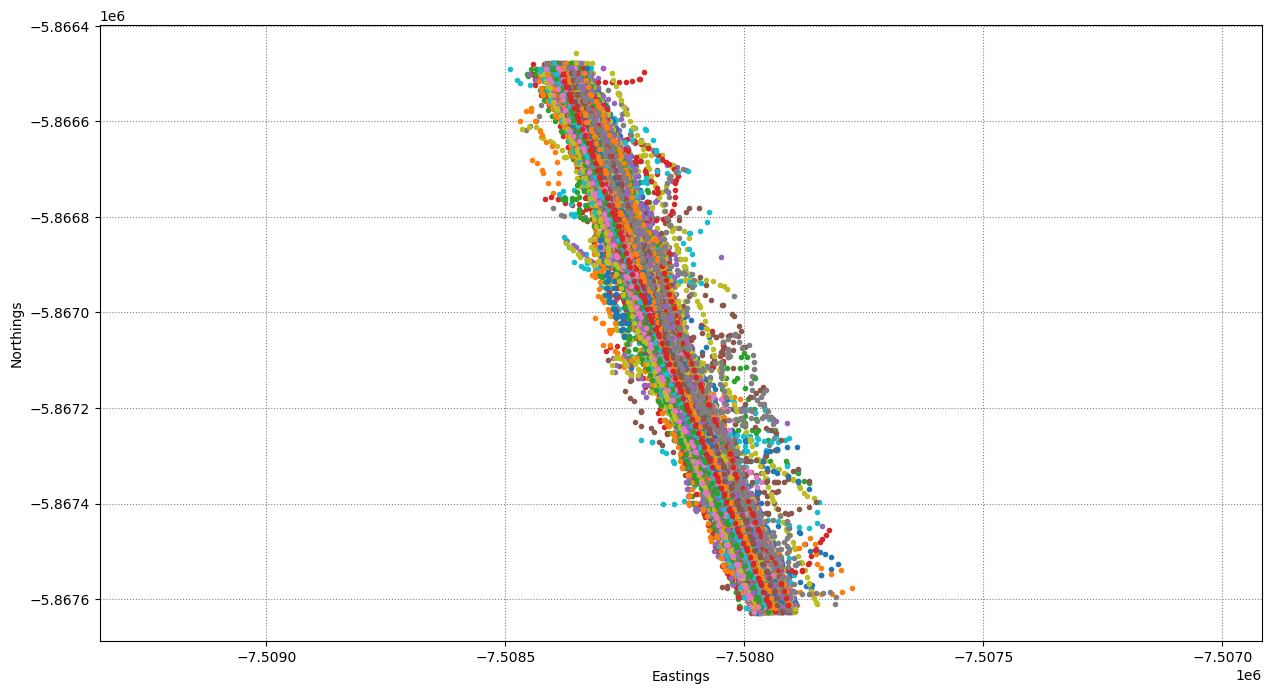

In [50]:
%matplotlib inline 
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.show()
# plt.legend();

## Shoreline analysis <a class="anchor" id="shoreline-analysis"></a>

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [51]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

33 duplicates
13 bad georef


There are 2 options to define the coordinates of the shore-normal transects:

**Option 1**: the user can interactively draw the shore-normal transects along the beach by calling:

In [52]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in Data/Caleta_Olivia/Output/data/Caleta_Olivia


**Option 2**: the user can load the transect coordinates (make sure the coordinate reference system (CRS) is the same as defined previously in `settings['output_epsg]`) from a .geojson file by calling:

In [ ]:
#geojson_file = os.path.join(os.getcwd(), 'Data', sitename+'.geojson')
#transects = SDS_tools.transects_from_geojson(geojson_file)

Plot the location of the transects, make sure they are in the right location with the origin always landwards! Also check that the transects are intersecting the mapped shorelines.

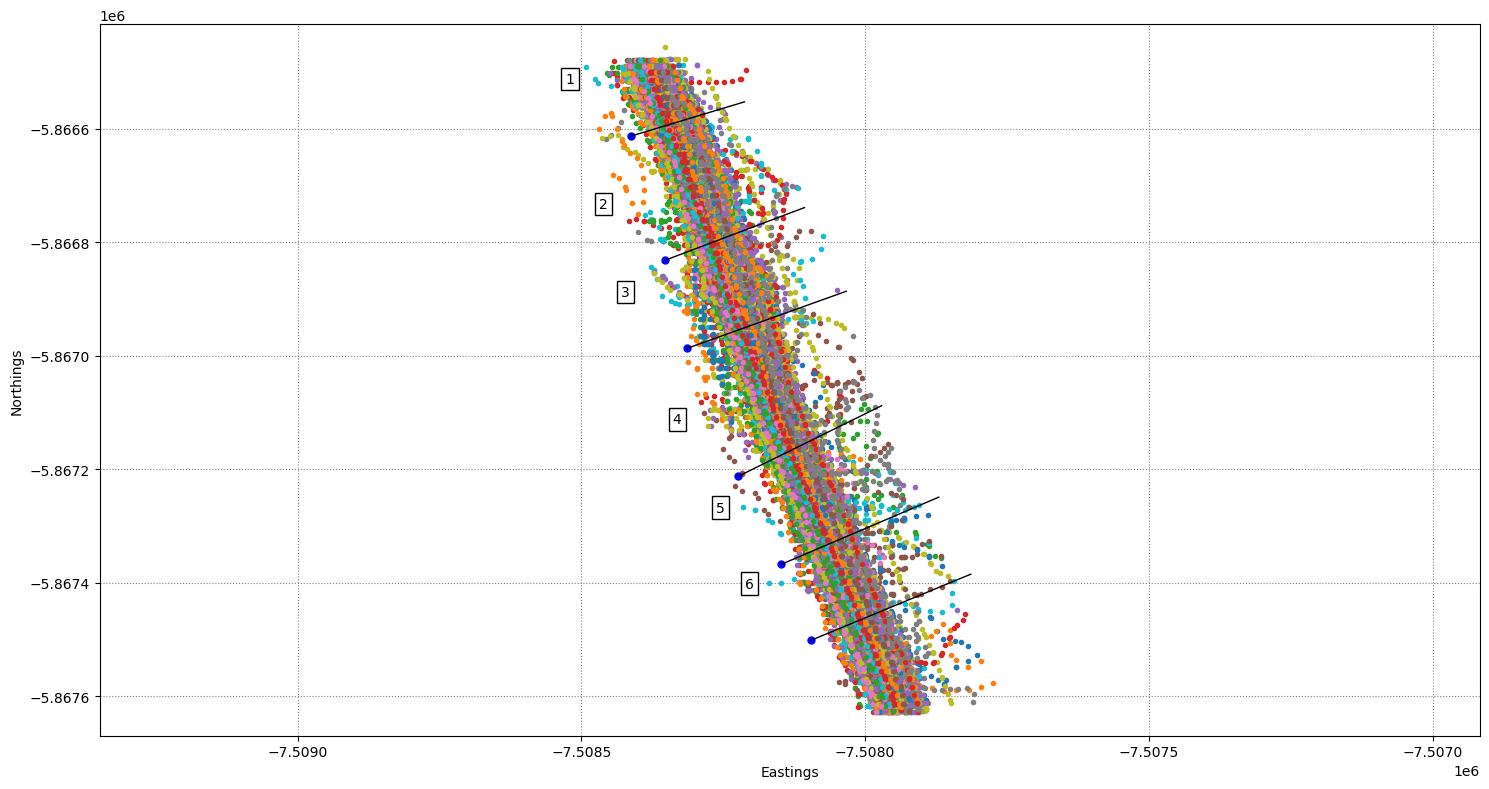

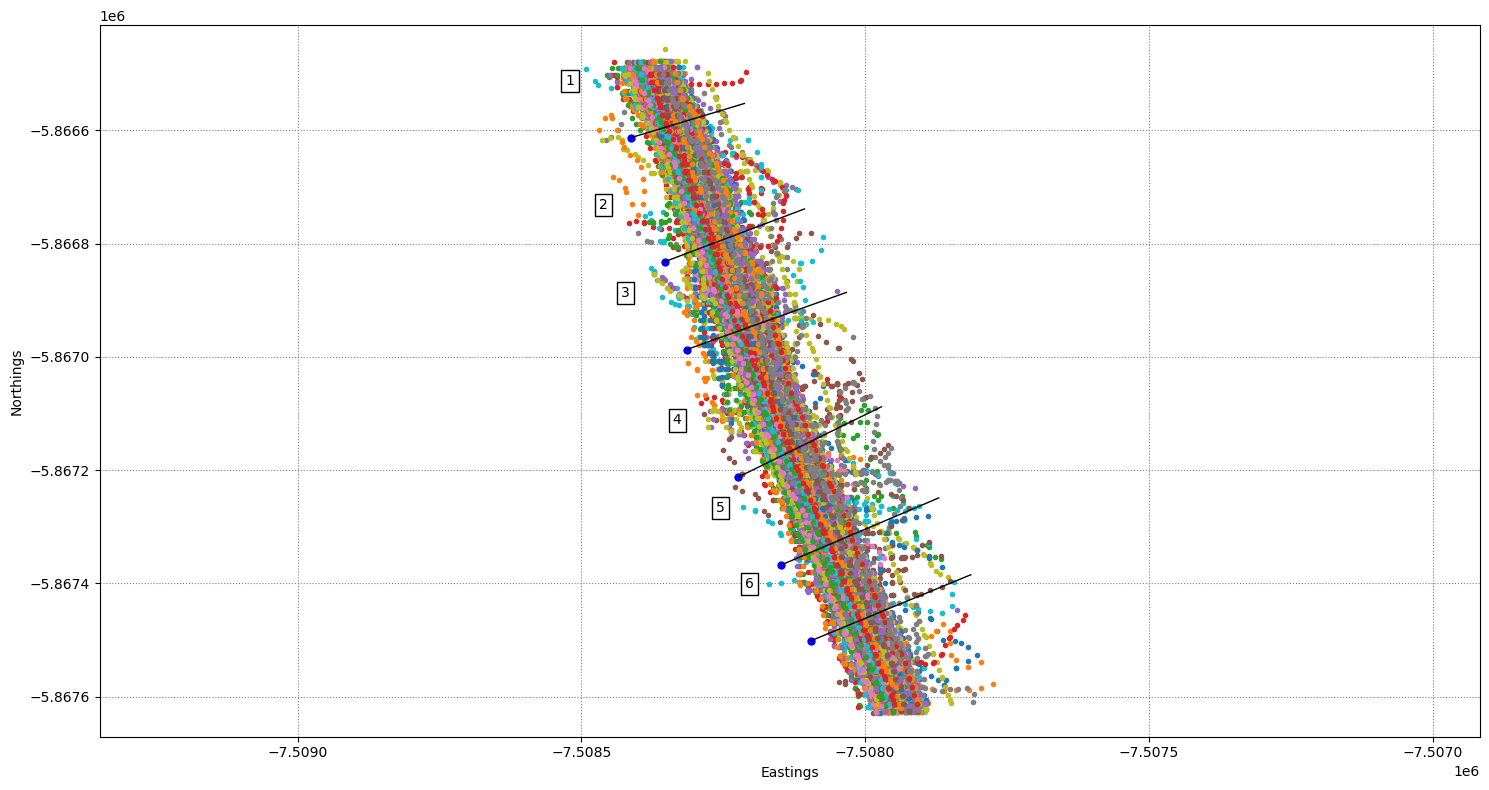

In [55]:

%matplotlib inline 
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
fig.savefig(os.path.join(img_dir,'%s_mapped_shorelines.jpg'%sitename),dpi=300)
plt.show()

Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect. The shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [56]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Plot the time-series of shoreline change along each transect

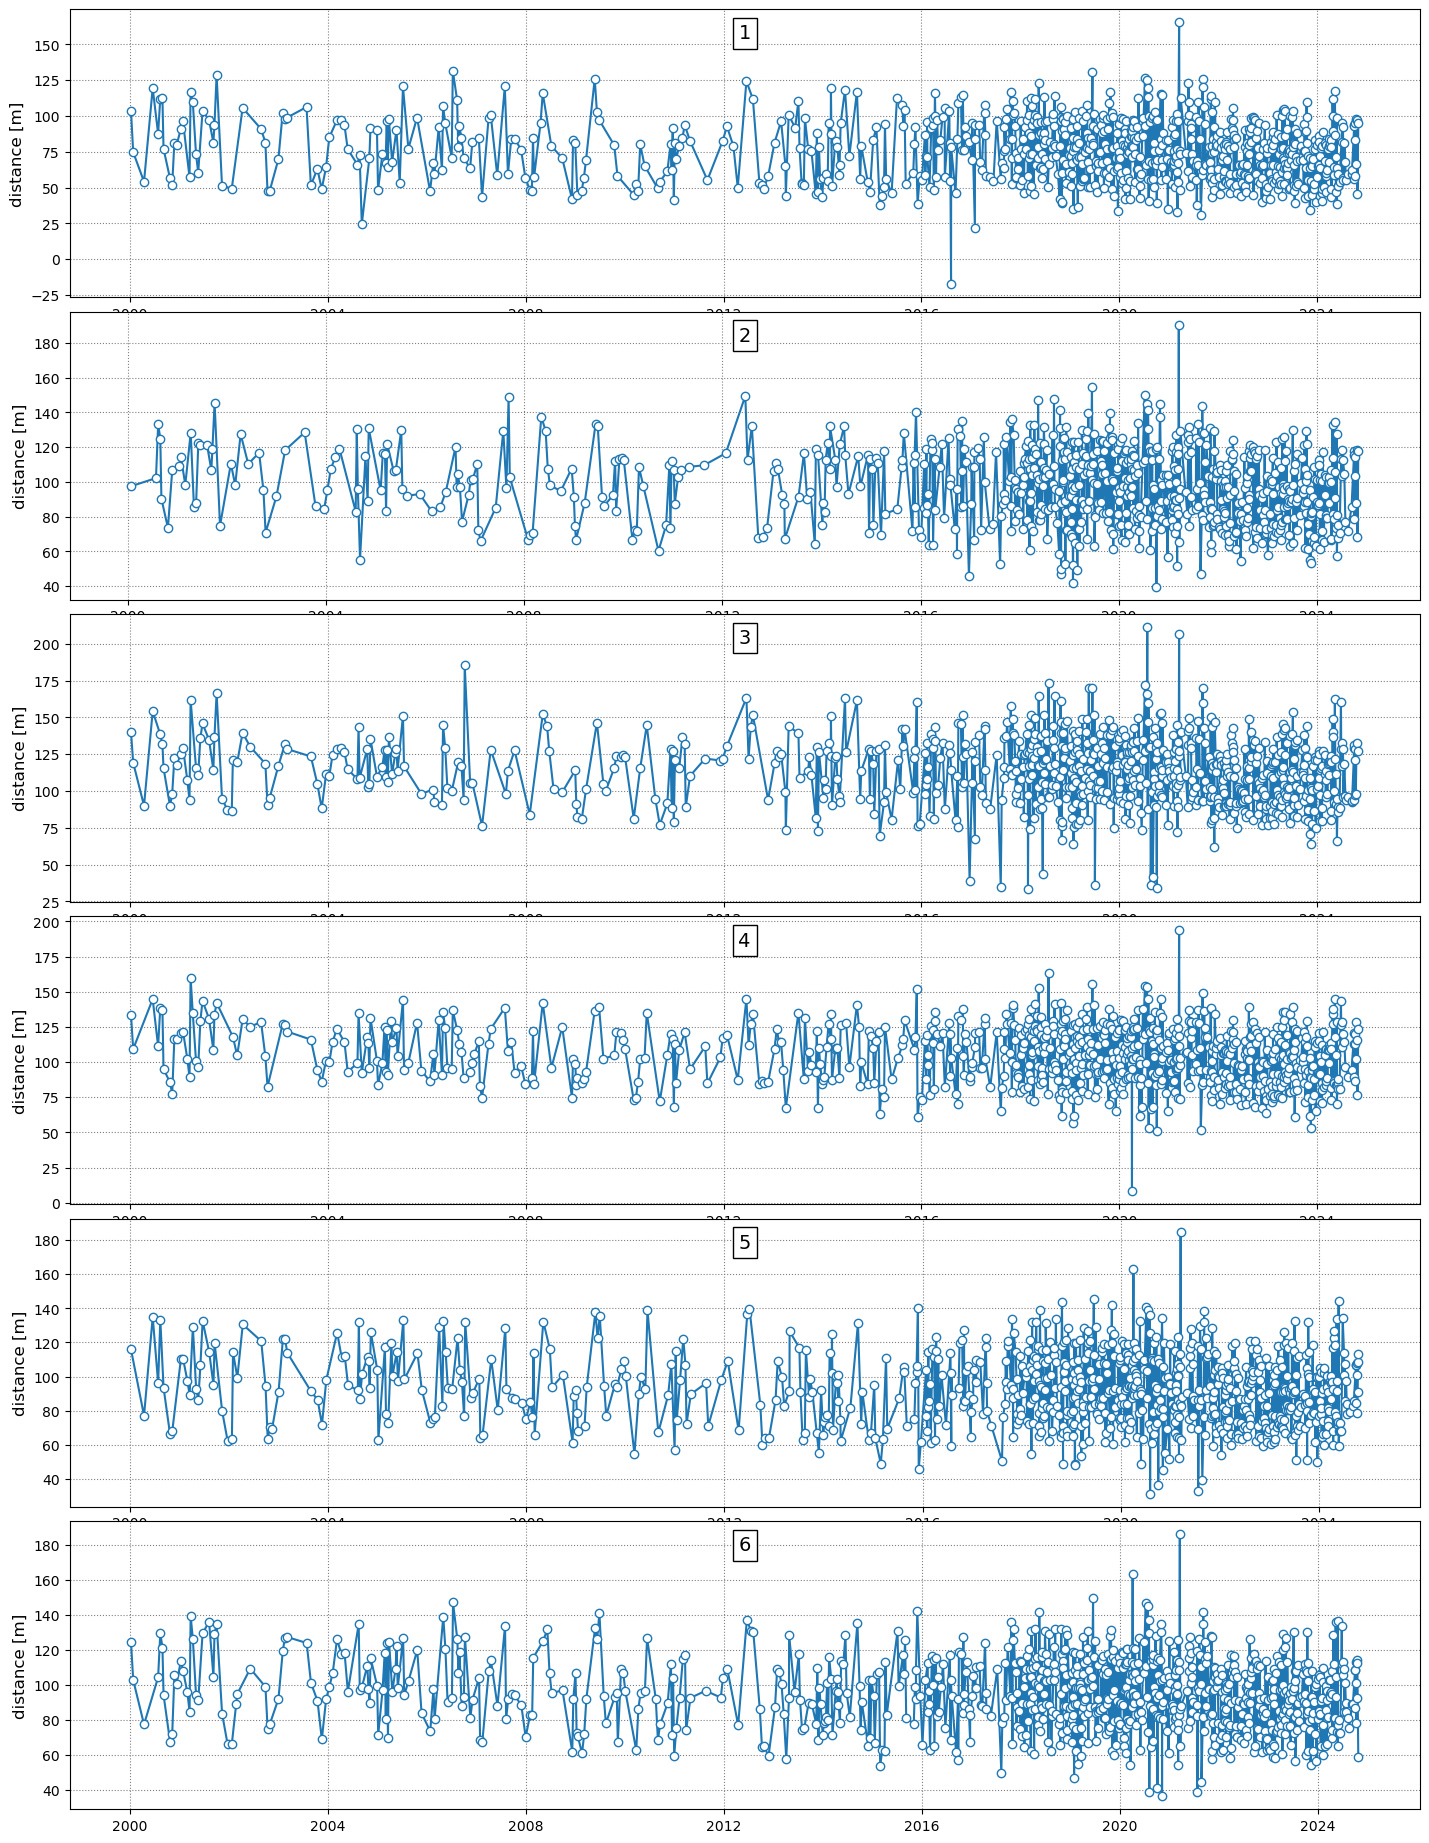

In [57]:
%matplotlib inline
fig = plt.figure(figsize=[15,20], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
fig.savefig(os.path.join(img_dir,'%s_timeseries_raw.jpg'%sitename),dpi=200)
plt.show()

In [60]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(output_dir,'%s_time_series_raw.csv'%sitename)
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
Data/Caleta_Olivia/Output/data/Caleta_Olivia_time_series_raw.csv


## Tidal correction

Here, we load the water level data that were extracted in the `Calculate_Tides` notebook. Tides and satellite times are compared and the closest water levels to the satellite image acquisition time are calculated.

In [76]:
dates_sat = output['dates']
tides_path = os.path.join('Data',sitename,'water_levels','FES2022_tides_Caleta_Olivia.csv')
tides_df = pd.read_csv(tides_path)
# load the measured tide data
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tides_df['dates']]
tides_ts = np.array(tides_df['tide'])
# get tide levels corresponding to the time of image acquisition
tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)

Extracting closest points: 100%

Everything is plotted together. Plotting can take a long time, but it helps checking the data.

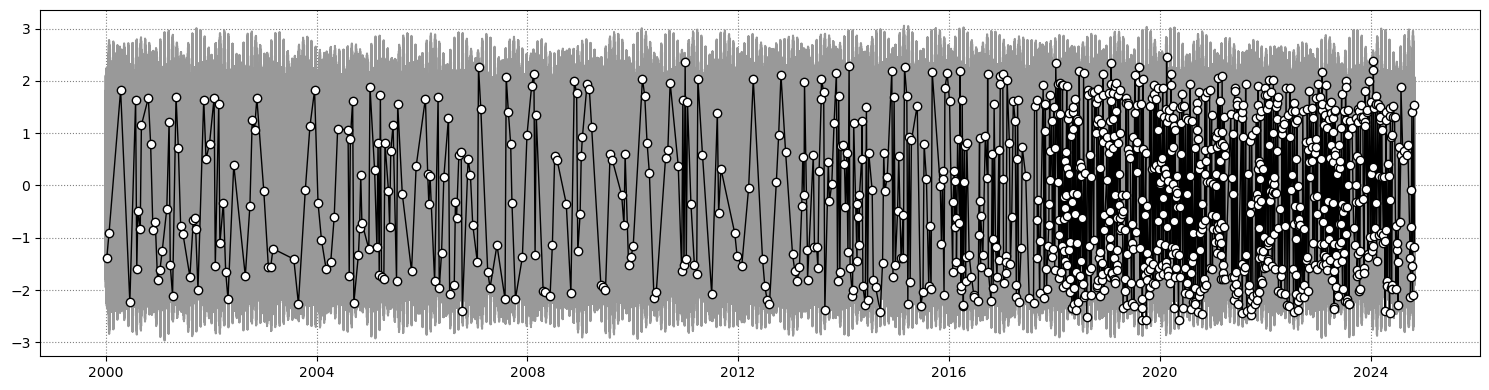

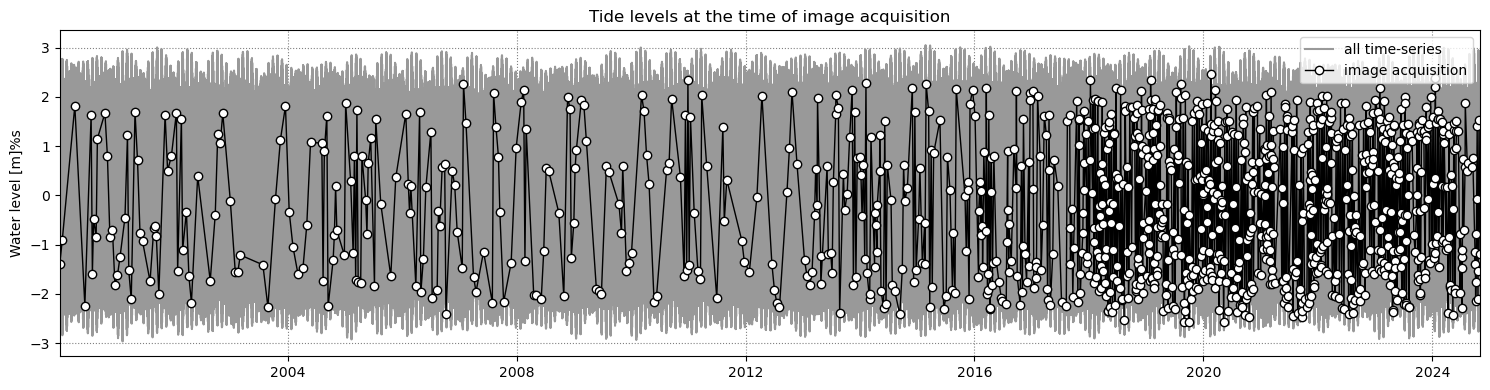

In [78]:
%matplotlib inline
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='Water level [m]%s',xlim=[dates_sat[0],dates_sat[-1]], title='Tide levels at the time of image acquisition');
ax.legend()

fig.savefig(os.path.join(img_dir,'%s_tide_timeseries.jpg'%sitename),dpi=300)
plt.show()

## Beach slope estimation

**Satellite-derived shorelines from Landsat 5, 7 and 8 between 1999 and 2020 are needed to estimate the beach slope**, these have to be mapped with CoastSat beforehand. When mapping shorelines with CoastSat, the coordinates of the 2D shorelines are saved in a file named `sitename_output.pkl`. When preparing your own files, make sure that both files are in the same coordinate system.

The section below loads the two files, removes duplicates and shorelines with poor georeferencing and plots the 2D shorelines and cross-shore transects.

More details on the slope estimation methodology are [Vos et al. 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL088365) and [Vos et al. 2022](https://essd.copernicus.org/articles/14/1345/2022/). 

For a more detailed tutorial visit the [CoastSat.slope repository](https://github.com/kvos/CoastSat.slope/tree/master).

In [79]:
# Make a deep copy of cross_distance to avoid rewriting it
import copy
cross_distance_slope = copy.deepcopy(cross_distance)

In [ ]:
#%matplotlib inline
# plot time-series
#SDS_slope.plot_cross_distance(output['dates'],cross_distance_slope)
#plt.show()

In [80]:
# slope estimation settings
days_in_year = 365.2425
seconds_in_day = 24*3600
settings_slope = {'slope_min':        0.001,                  # minimum slope to trial
                  'slope_max':        0.5,                    # maximum slope to trial
                  'delta_slope':      0.005,                  # slope increment
                  'n0':               50,                     # parameter for Nyquist criterium in Lomb-Scargle transforms
                  'freq_cutoff':     1./(seconds_in_day*30), # 1 month frequency
                  'delta_f':          100*1e-10,              # deltaf for identifying peak tidal frequency band
                  'prc_conf':         0.05,                   # percentage above minimum to define confidence bands in energy curve
                  'plot_fig':         False,                   # whether to plot the intermediary products during analysis
                  }
# range of slopes to test for
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])

In [82]:
# range of dates over which to perform the analysis (2 Landsat satellites)
settings_slope['date_range'] = [1999,2024]
# re-write in datetime objects (same as shoreline in UTC)
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0],5,1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1],1,1))]

# clip the time-series between 1999 and 2024 as we need at least 2 Landsat satellites 
idx_dates = [np.logical_and(_>settings_slope['date_range'][0],_<settings_slope['date_range'][1]) for _ in output['dates']]
dates_slope = [output['dates'][_] for _ in np.where(idx_dates)[0]]

for key in cross_distance_slope.keys():
    cross_distance_slope[key] = cross_distance_slope[key][idx_dates]
    
tides_slope = SDS_tools.get_closest_datapoint(dates_slope, dates_ts, tides_ts)

Extracting closest points: 100%

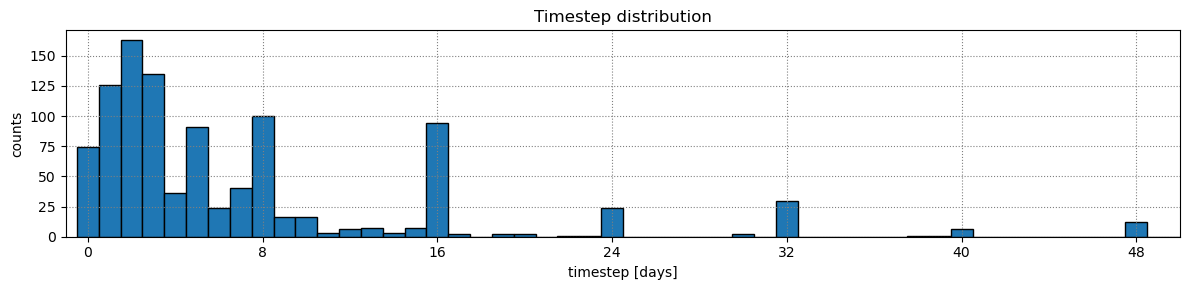

In [83]:
slopes_path = os.path.join('Data',sitename,'slope_estimation')

SDS_slope.plot_timestep(dates_slope)
plt.gcf().savefig(os.path.join(slopes_path,'0_timestep_distribution.jpg'),dpi=200)
plt.show()

In [84]:
# sampling period [days]
settings_slope['n_days'] = 8

In [85]:
settings_slope['freqs_max'] = SDS_slope.find_tide_peak(dates_slope,tides_slope,settings_slope)
plt.gcf().savefig(os.path.join(slopes_path,'1_tides_power_spectrum.jpg'),dpi=200)
plt.show()

<Figure size 640x480 with 0 Axes>

Beach slope at transect 1: 0.076 (0.0710 - 0.0810)
Beach slope at transect 2: 0.071 (0.0635 - 0.0760)
Beach slope at transect 3: 0.076 (0.0685 - 0.0810)
Beach slope at transect 4: 0.086 (0.0810 - 0.0910)
Beach slope at transect 5: 0.076 (0.0710 - 0.0860)
Beach slope at transect 6: 0.081 (0.0785 - 0.0885)


<Figure size 640x480 with 0 Axes>

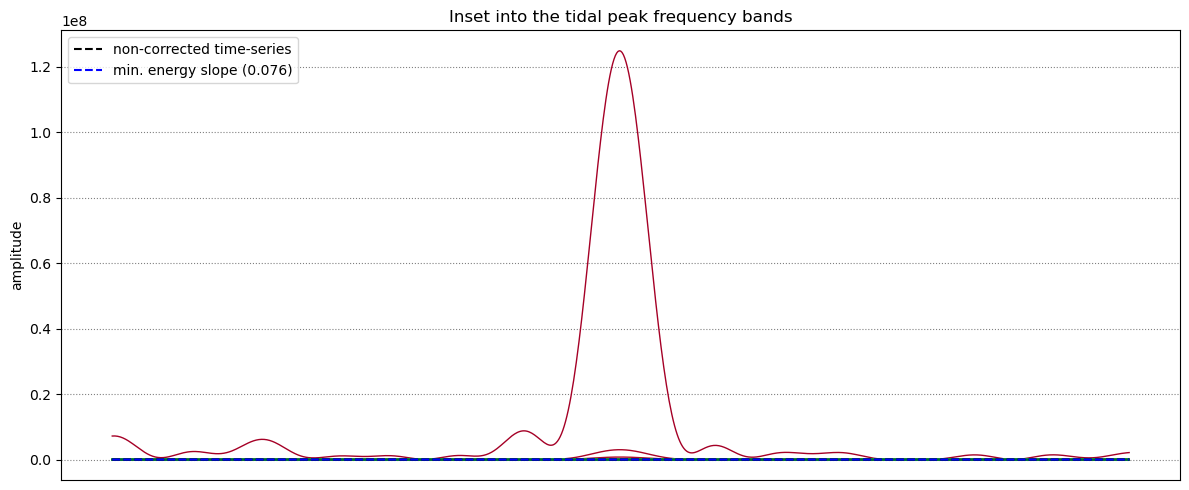

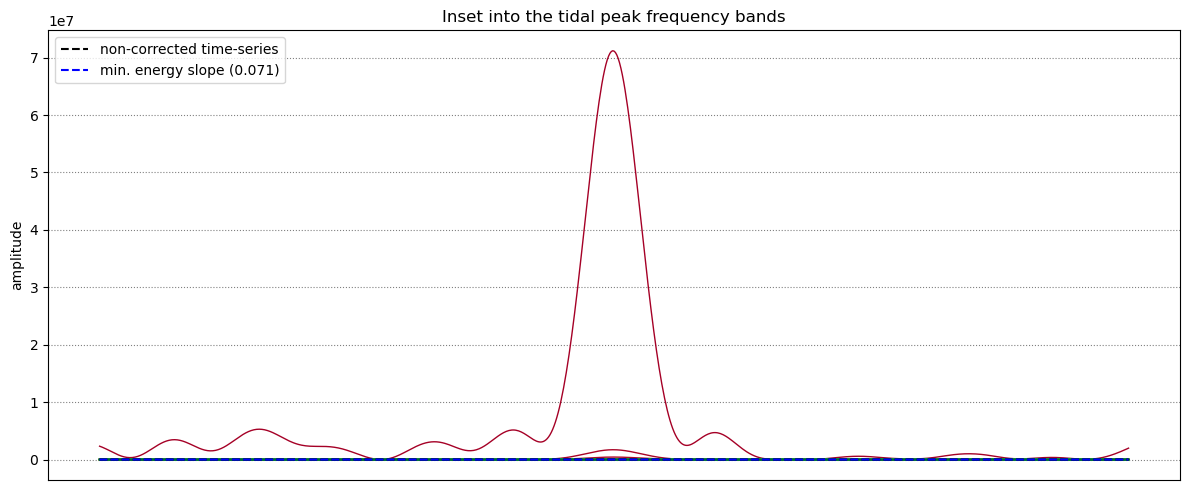

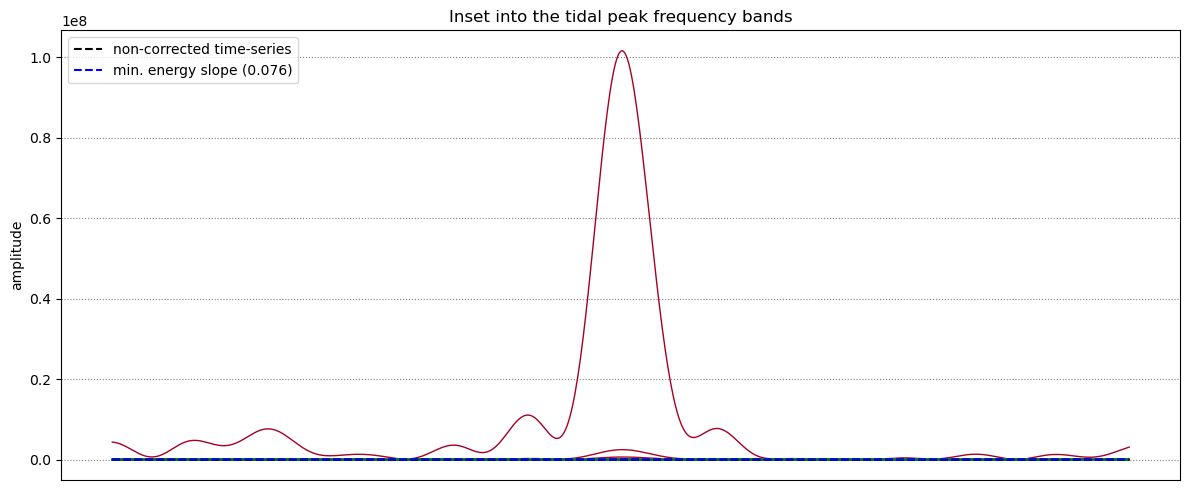

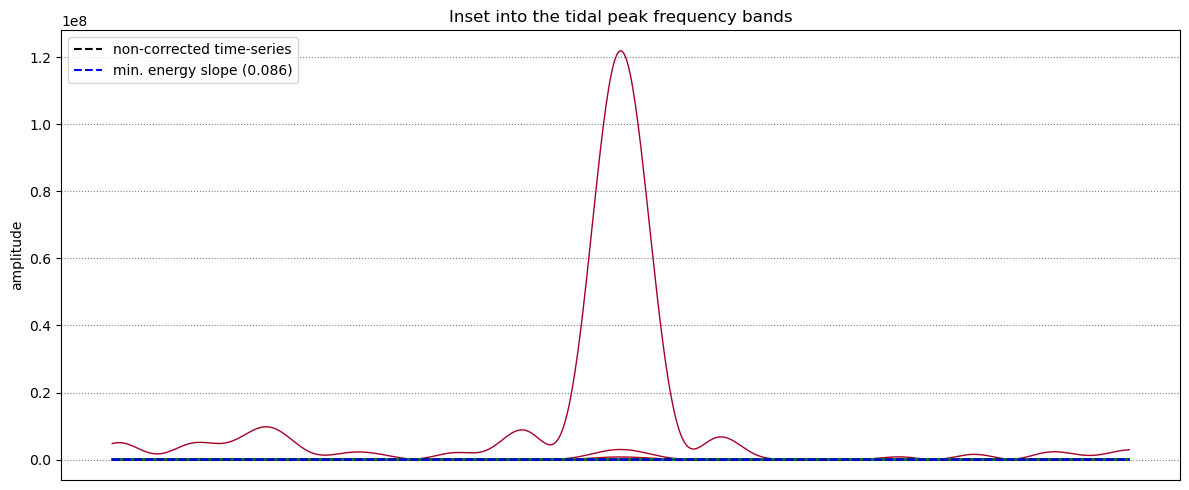

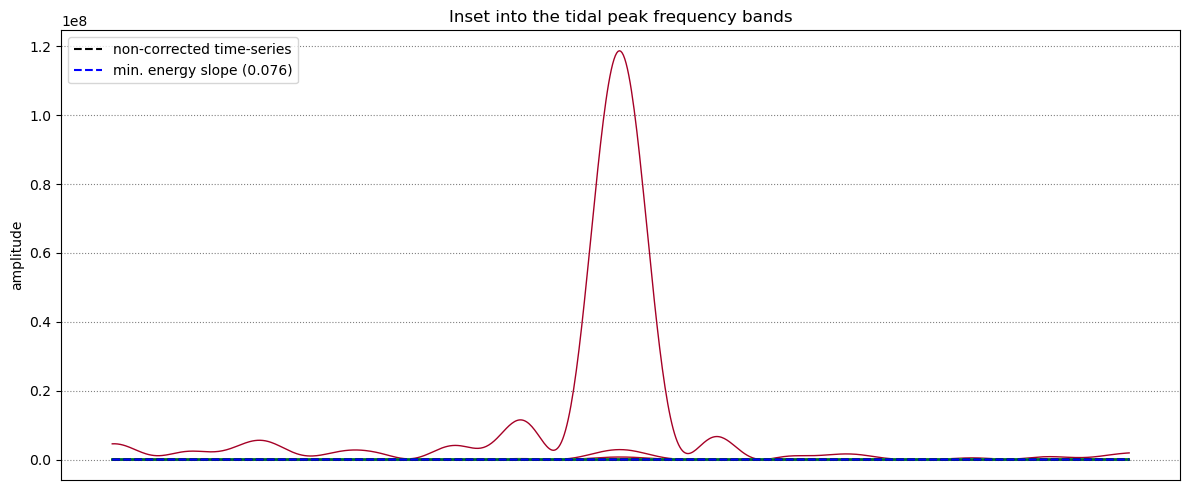

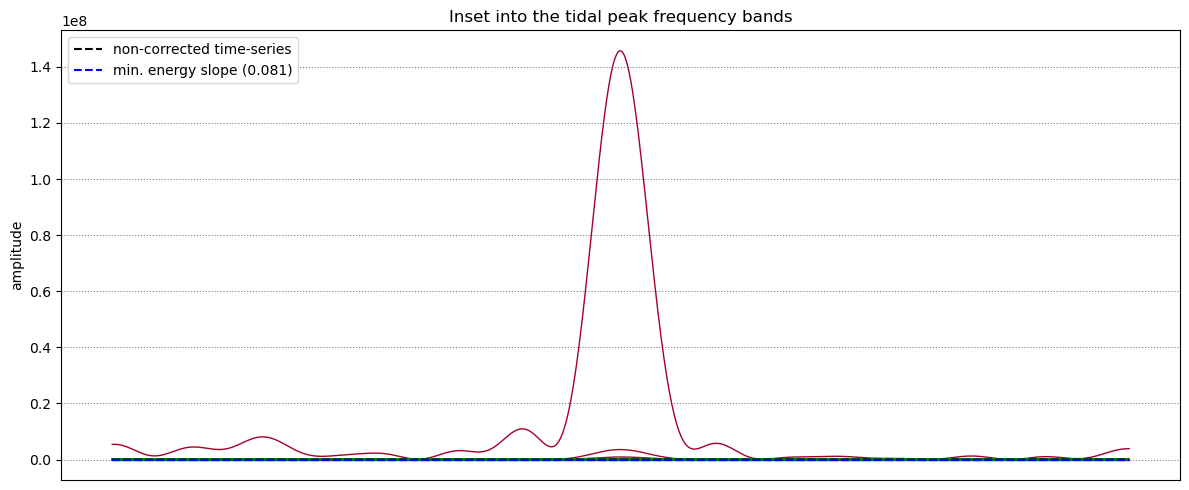

In [86]:
# estimate beach-face slopes along the transects
slope_est, cis = dict([]), dict([])
for key in cross_distance_slope.keys():
    # remove NaNs
    idx_nan = np.isnan(cross_distance_slope[key])
    dates = [dates_slope[_] for _ in np.where(~idx_nan)[0]]
    tide = tides_slope[~idx_nan]
    composite = cross_distance_slope[key][~idx_nan]
    # apply tidal correction
    tsall = SDS_slope.tide_correct(composite,tide,beach_slopes)
    # estimate beach slope
    slope_est[key],cis[key] = SDS_slope.integrate_power_spectrum(dates,tsall,settings_slope, key)
    plt.gcf().savefig(os.path.join(slopes_path,'2_energy_curve_%s.jpg'%key),dpi=200)
    # plot spectrums
    SDS_slope.plot_spectrum_all(dates,composite,tsall,settings_slope,slope_est[key])
    plt.gcf().savefig(os.path.join(slopes_path,'3_slope_spectrum_%s.jpg'%key),dpi=200)
    print('Beach slope at transect %s: %.3f (%.4f - %.4f)'%(key, slope_est[key], cis[key][0], cis[key][1]))
plt.show()

From the 5-95% confidence interval above, we plot the slopes and calculate the average slope.

## Tidal correction

Apply tidal correction using a linear slope and a reference elevation to which project all the time-series of cross-shore change (to get time-series at Mean Sea Level, set reference_elevation to 0. The beach slope is set as the average of the gaussians described 

Data saved successfully to Data/Caleta_Olivia/slope_estimation/slopes.csv


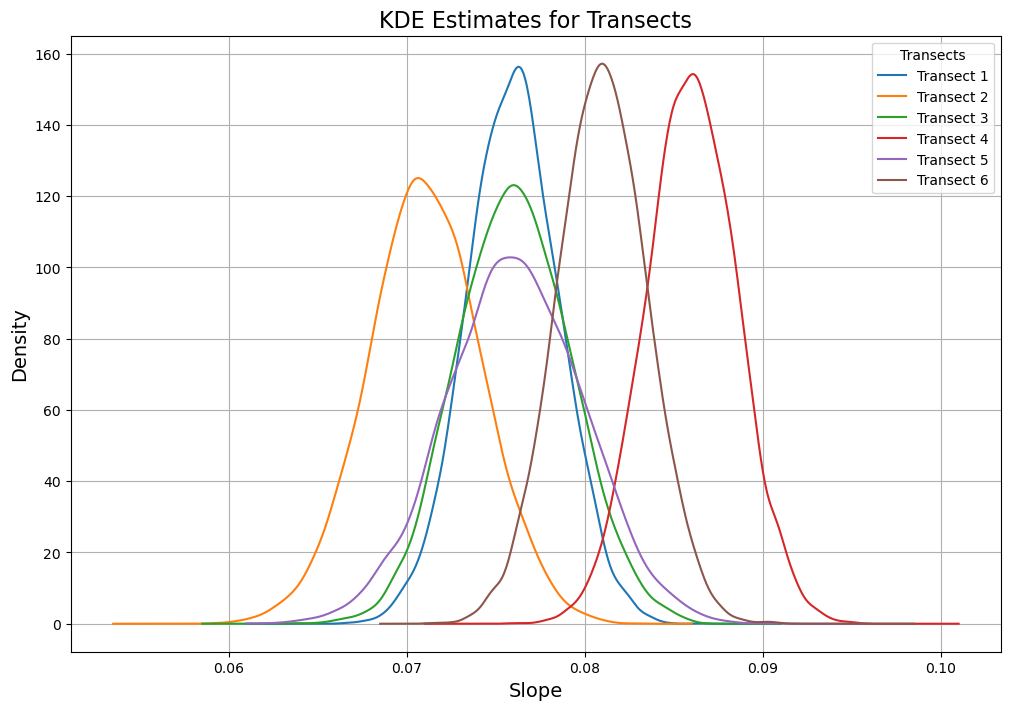

In [115]:
# Combine data from cis and slope_est
data = []
for transect, (ci_lower, ci_upper) in cis.items():
    slope = slope_est[transect]
    data.append({'Transect': transect, 'CI_Lower': ci_lower, 'CI_Upper': ci_upper, 'Slope': slope})

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
output_file = os.path.join(slopes_path,'slopes.csv')
df.to_csv(output_file, index=False)

print(f"Data saved successfully to {output_file}")

from scipy.stats import gaussian_kde

# Set up the plot
plt.figure(figsize=(12, 8))

for transect, mean_slope in slope_est.items():
    # Extract confidence intervals
    ci_lower, ci_upper = cis[transect]
    
    # Estimate standard deviation from confidence intervals (assuming normality)
    std_dev = (ci_upper - ci_lower) / 3.92  # Approximation using 95% CI width
    
    # Generate random samples from the normal distribution
    samples = np.random.normal(loc=mean_slope, scale=std_dev, size=10000)
    
    # Calculate the KDE
    kde = gaussian_kde(samples)
    x_vals = np.linspace(ci_lower - 0.01, ci_upper + 0.01, 500)  # Generate points for KDE plot
    y_vals = kde(x_vals)
    
    # Plot the KDE
    plt.plot(x_vals, y_vals, label=f'Transect {transect}')

# Customize plot
plt.title('KDE Estimates for Transects', fontsize=16)
plt.xlabel('Slope', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Transects')
plt.grid(True)
plt.show()

Tidally-corrected time-series of the shoreline change along the transects saved as:
Data/Caleta_Olivia/Output/data/transect_time_series_tidally_corrected.csv


<Figure size 640x480 with 0 Axes>

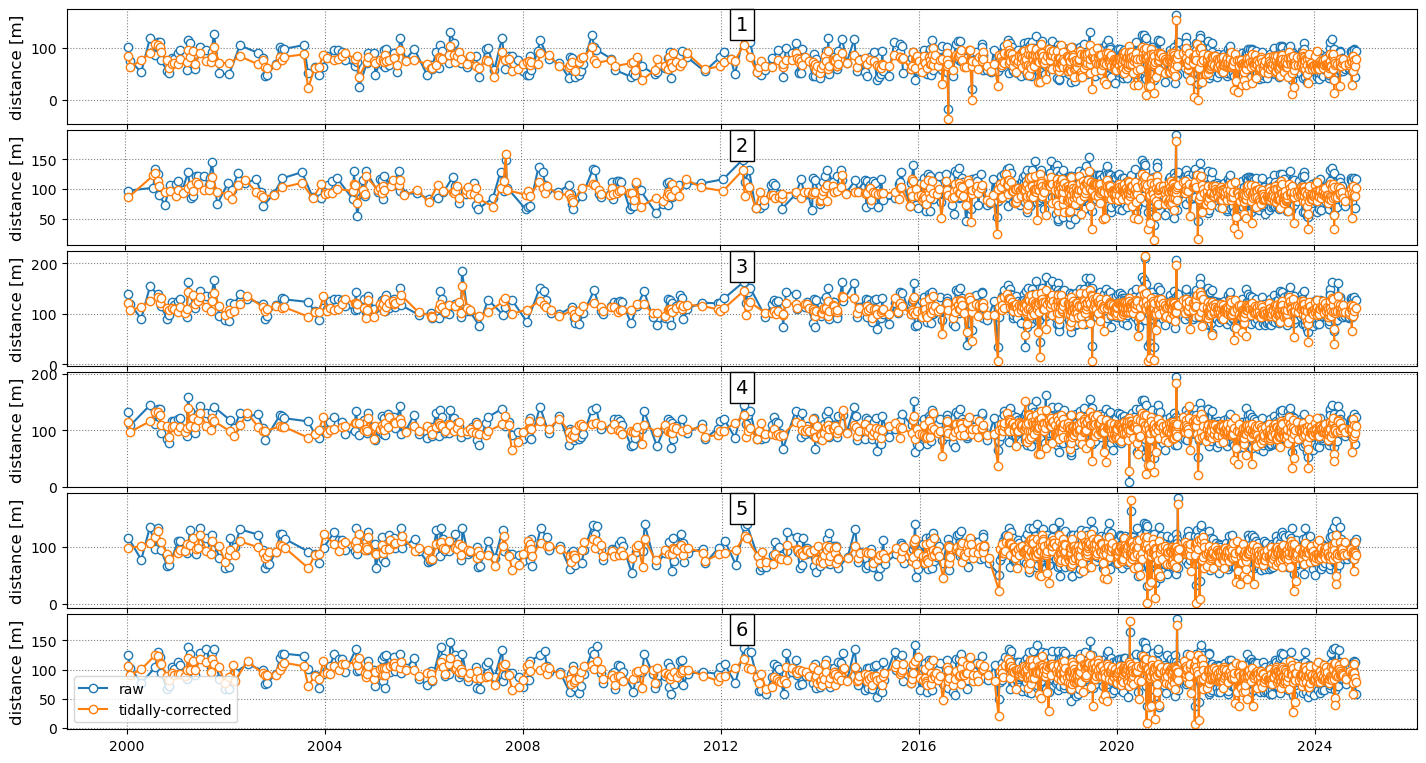

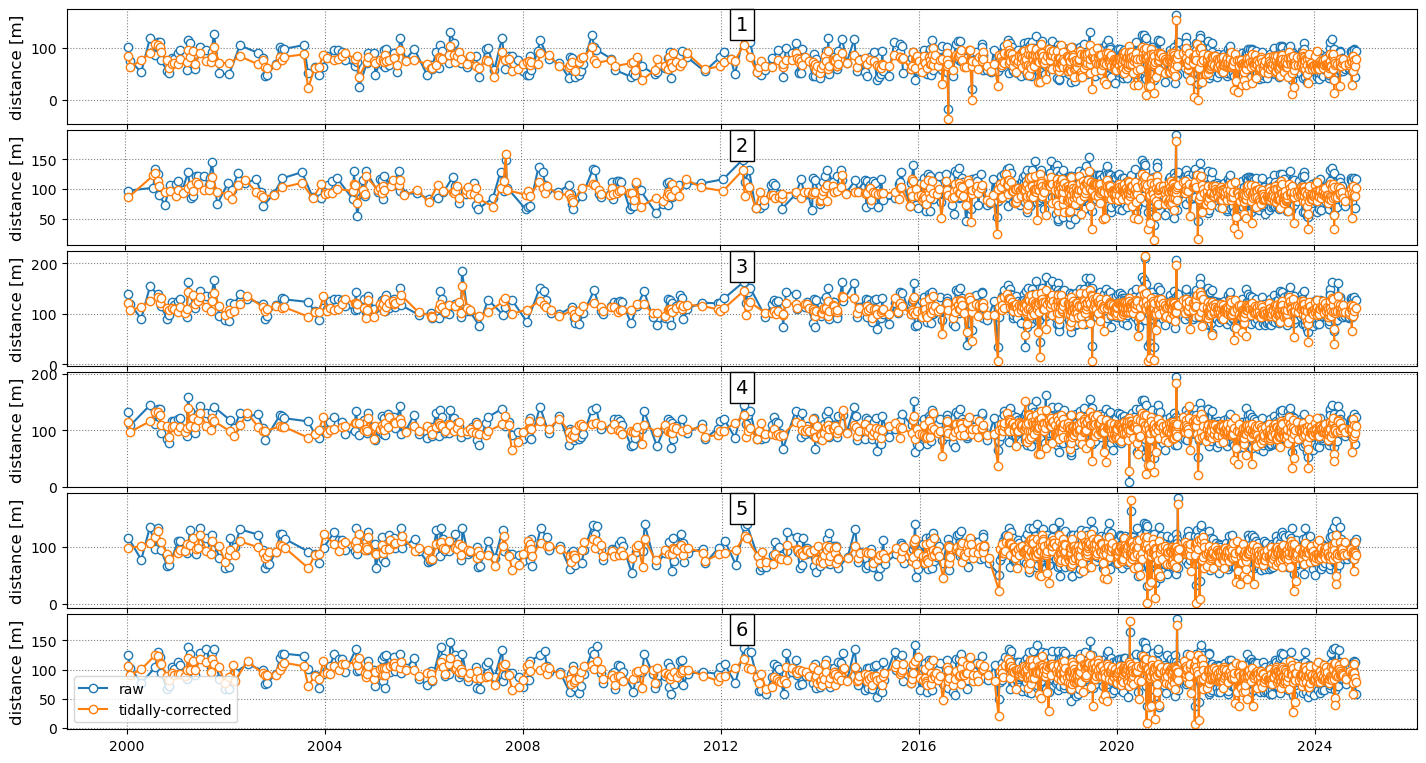

In [92]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be

# Takes the average slope calculated above
beach_slope = avg_slope

cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(output_dir,'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    idx_nan = np.isnan(cross_distance[key])
    dates = [output['dates'][_] for _ in np.where(~idx_nan)[0]]
    chainage = cross_distance[key][~idx_nan]
    chainage_corrected = cross_distance_tidally_corrected[key][~idx_nan]
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(dates, chainage, '-o', ms=6, mfc='w', label='raw')
    ax.plot(dates, chainage_corrected, '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend()
fig.savefig(os.path.join(img_dir,'%s_timeseries_corrected.jpg'%sitename),dpi=200)
plt.show()

## Time-series post-processing

Finally, we can post-process the time-series of shoreline change to remove obvious outliers and spikes in the data and average the time-series over different time-frames (seasonally or monthly).

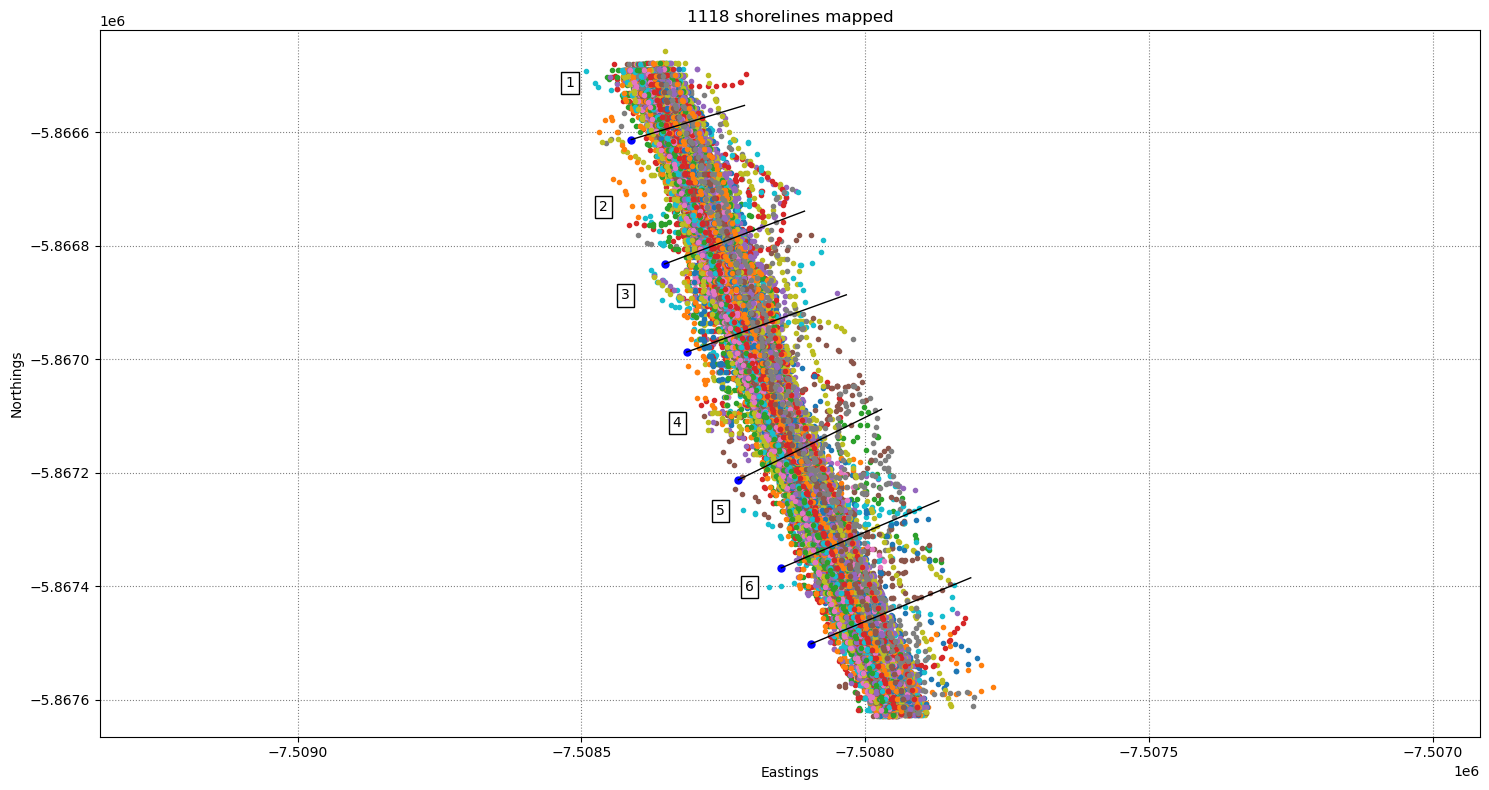

In [93]:
# plot the mapped shorelines
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title('%d shorelines mapped'%len(output['shorelines']))
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
             va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

# load long time-series
filename_ts = os.path.join(output_dir,'transect_time_series_tidally_corrected.csv')
df = pd.read_csv(filename_ts, parse_dates=['dates'])
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict([])
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

### Despiking the time-series

The tidally-corrected time-series of shoreline change obtained with the steps above may still contain some outliers (from cloud shadows, false detections etc). The function `SDS_transects.reject_outliers()` was developed to remove obvious outliers in the time-series, by removing the points that do not make physical sense in a shoreline change setting. 

For example, the shoreline can experience rapid erosion after a large storm, but it will then take time to recover and return to its previous state. Therefore, if the shoreline erodes/accretes suddenly of a significant amount (`max_cross_change`) and then immediately returns to its previous state, this spike does not make any physical sense and can be considered an outlier. Additionally, this function also checks that the Otsu thresholds used to map the shoreline are within the typical range defined by `otsu_threshold`, with values outside this range identified as outliers.

1  - outliers removed: 118
2  - outliers removed: 112
3  - outliers removed: 112
4  - outliers removed: 120
5  - outliers removed: 122
*6  - outliers removed: 118


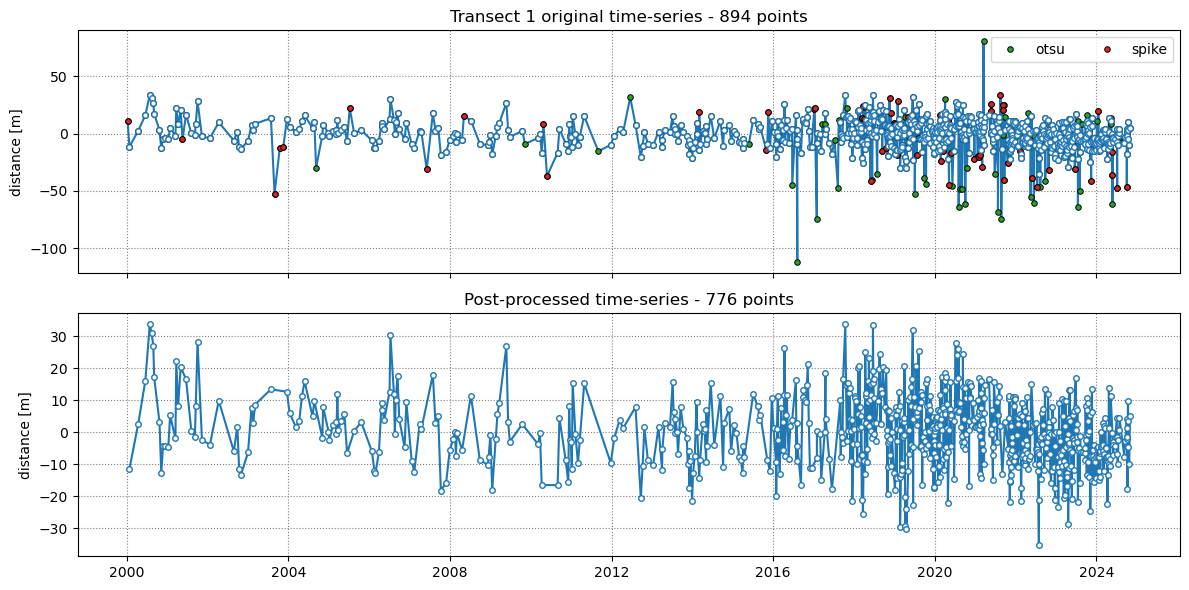

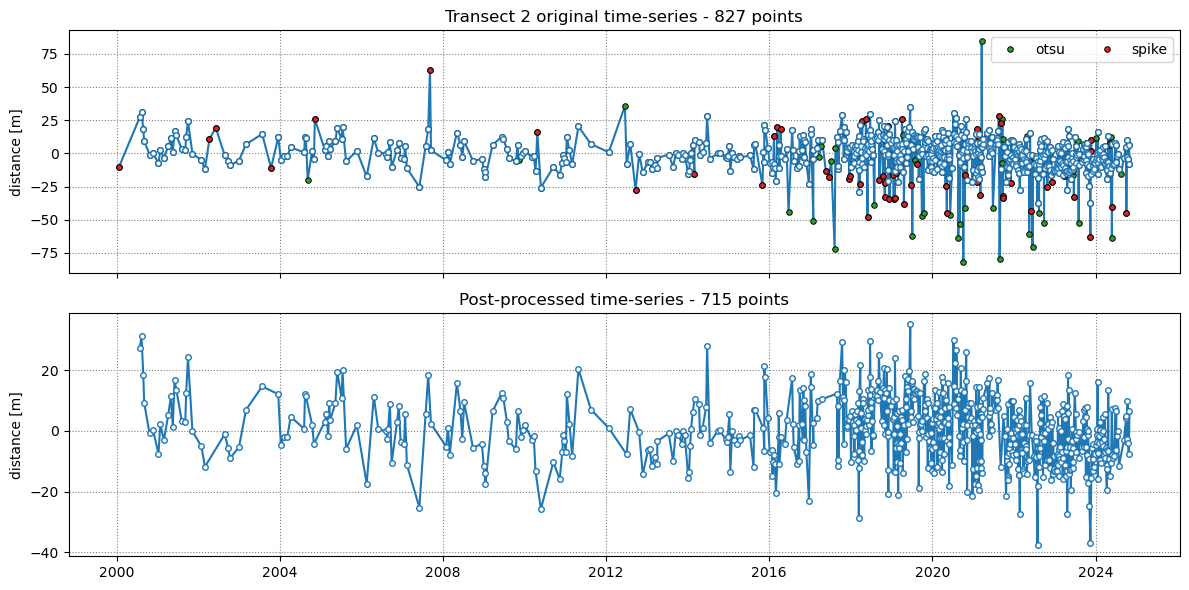

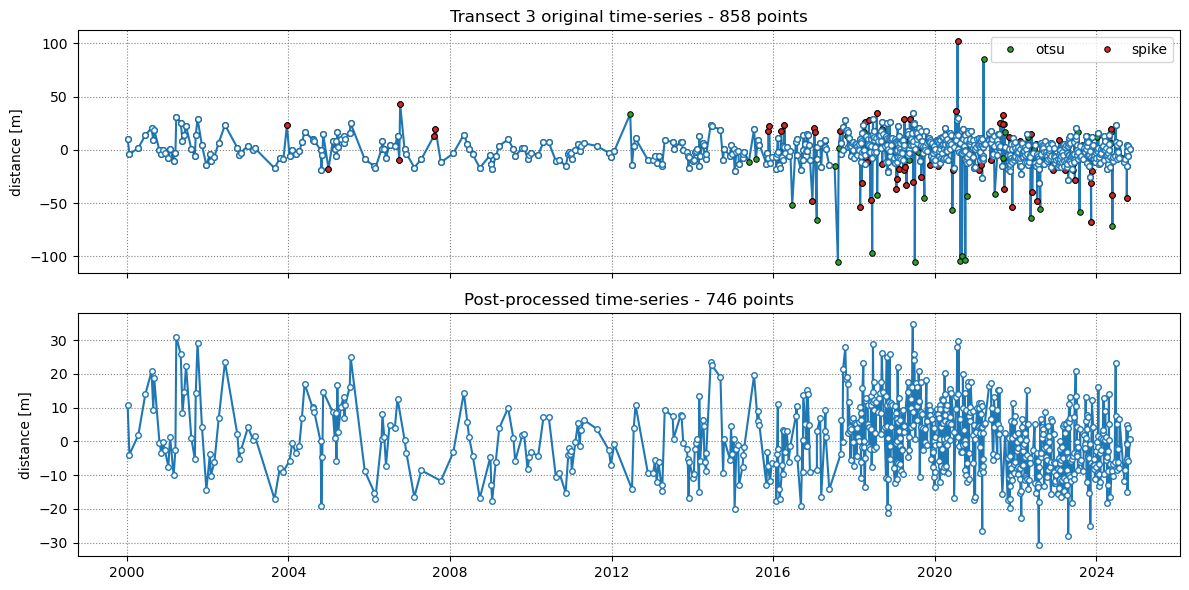

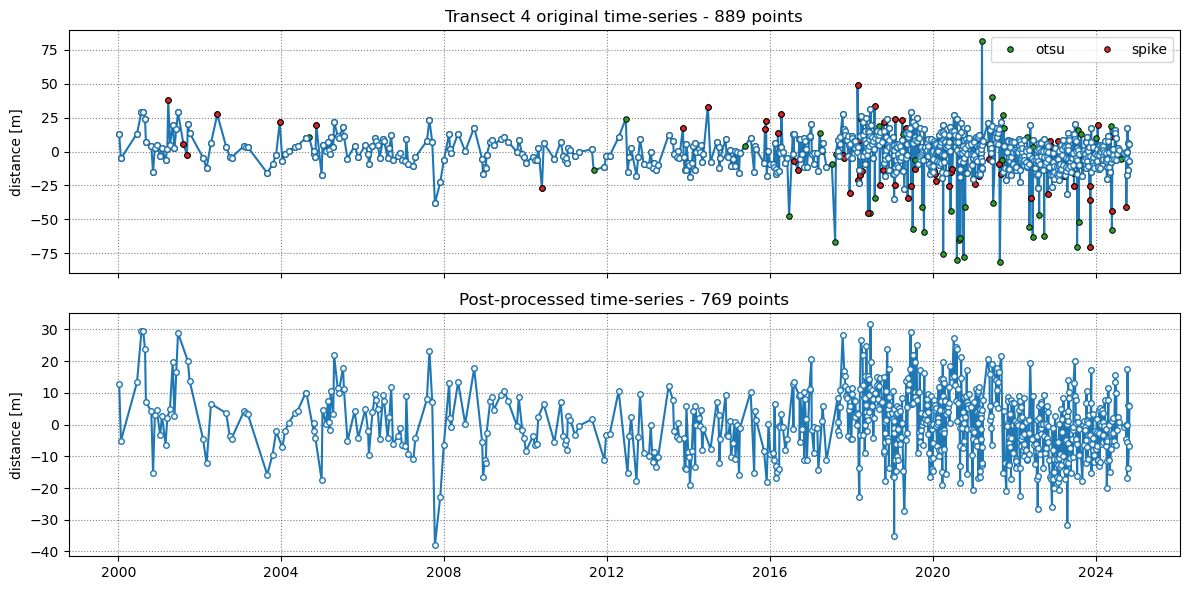

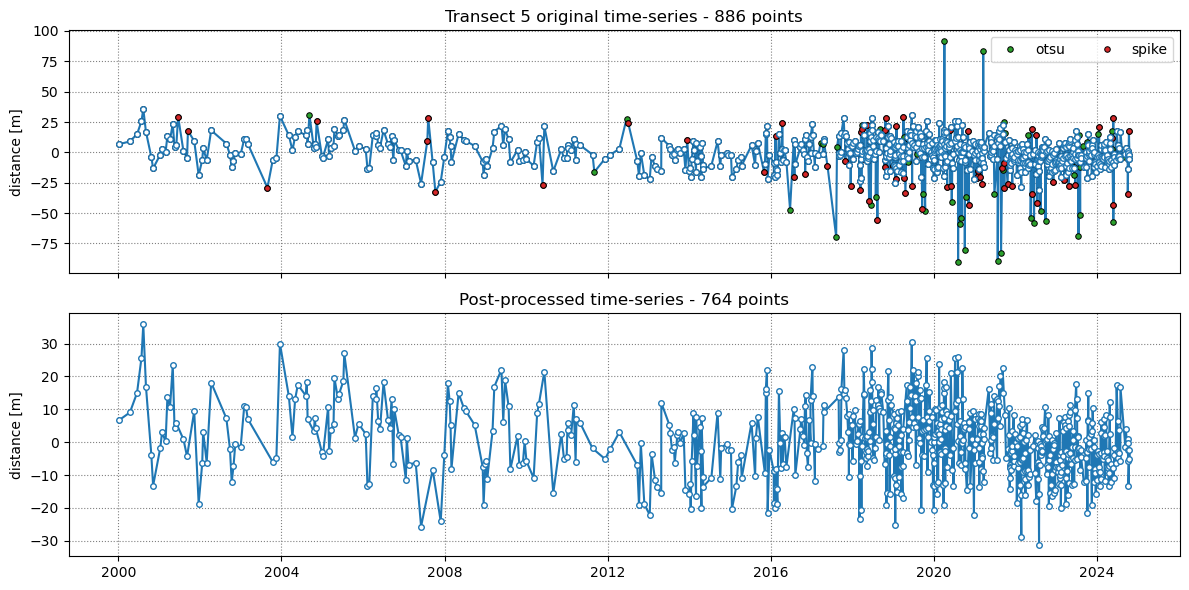

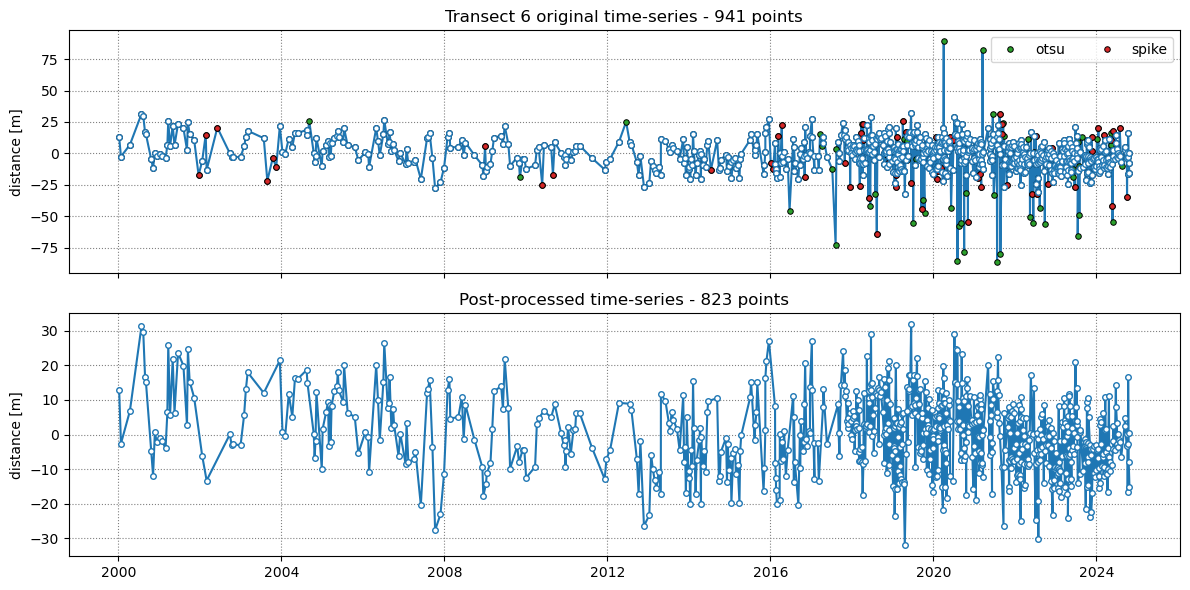

In [94]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   20,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)
plt.show()

We can also plot the Otsu threholds for the shorelines mapped at this site to see if there are any obvious outliers and adjust the values of `otsu_threshold`.

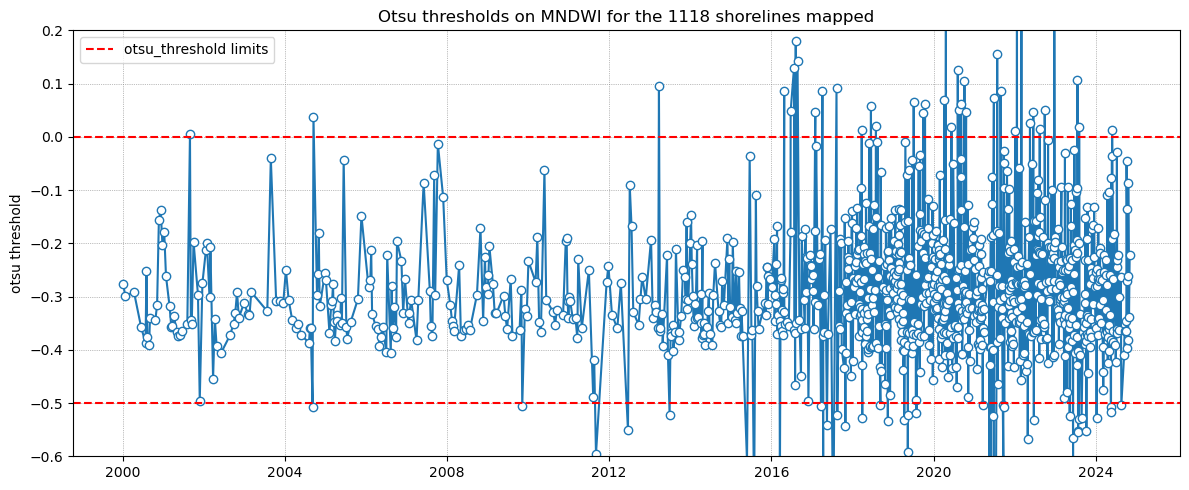

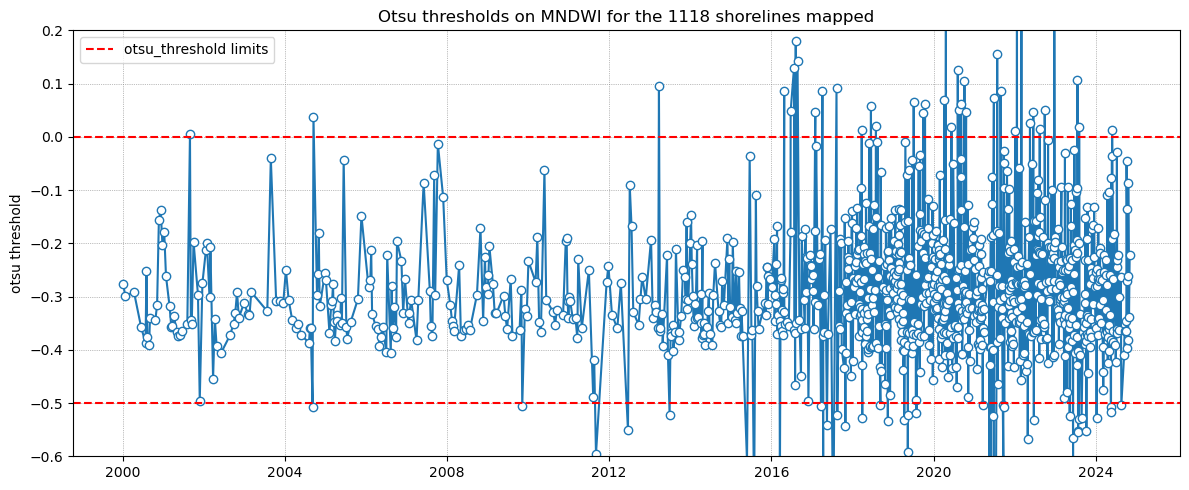

In [96]:
# plot Otsu thresholds for the mapped shorelines
fig,ax = plt.subplots(1,1,figsize=[12,5],tight_layout=True)
ax.grid(which='major',ls=':',lw=0.5,c='0.5')
ax.plot(output['dates'],output['MNDWI_threshold'],'o-',mfc='w')
ax.axhline(y=-0.5,ls='--',c='r',label='otsu_threshold limits')
ax.axhline(y=0,ls='--',c='r')
ax.set(title='Otsu thresholds on MNDWI for the %d shorelines mapped'%len(output['shorelines']),
       ylim=[-0.6,0.2],ylabel='otsu threshold')
ax.legend(loc='upper left')
fig.savefig(os.path.join(img_dir,'%s_otsu_threhsolds.jpg'%sitename), dpi=200)
plt.show()

### Seasonal averaging and long-term trends

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.seasonal_average()` and calculate the long-term trend with `SDS_transects.calculate_trend()`.

Outputs will be saved in Data/Caleta_Olivia/Output/img/seasonal_timeseries


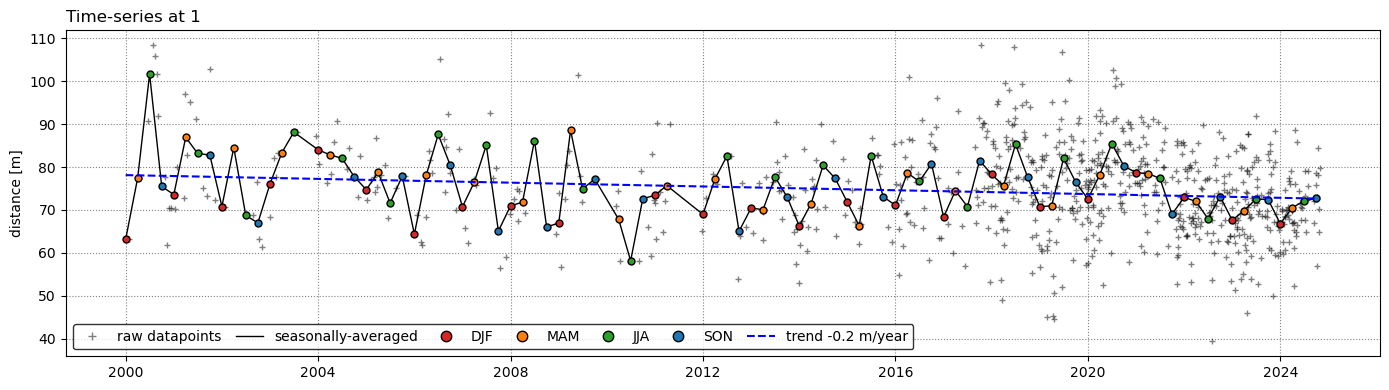

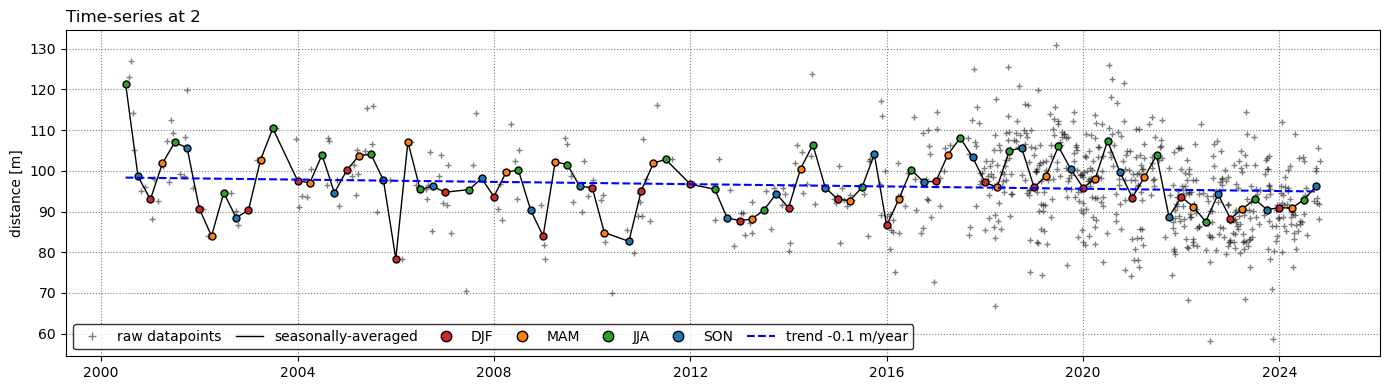

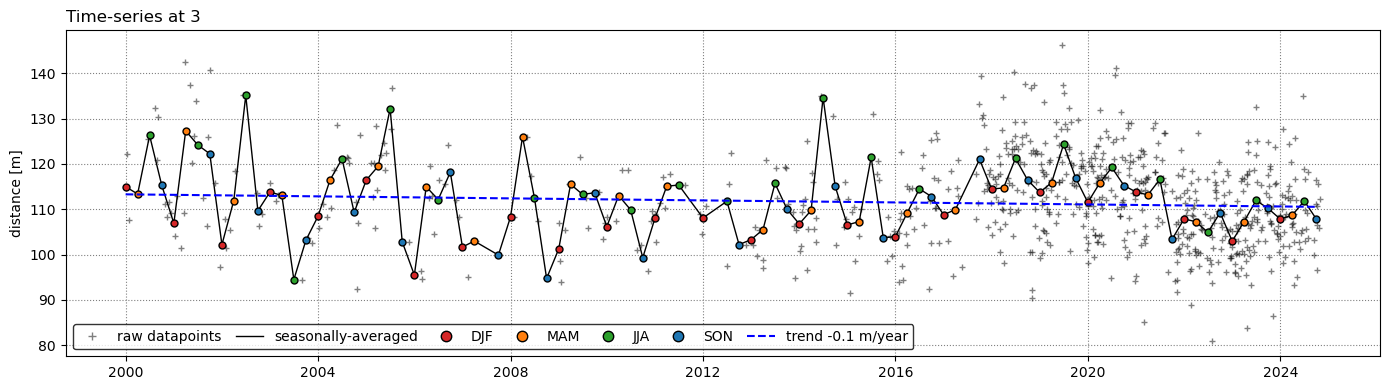

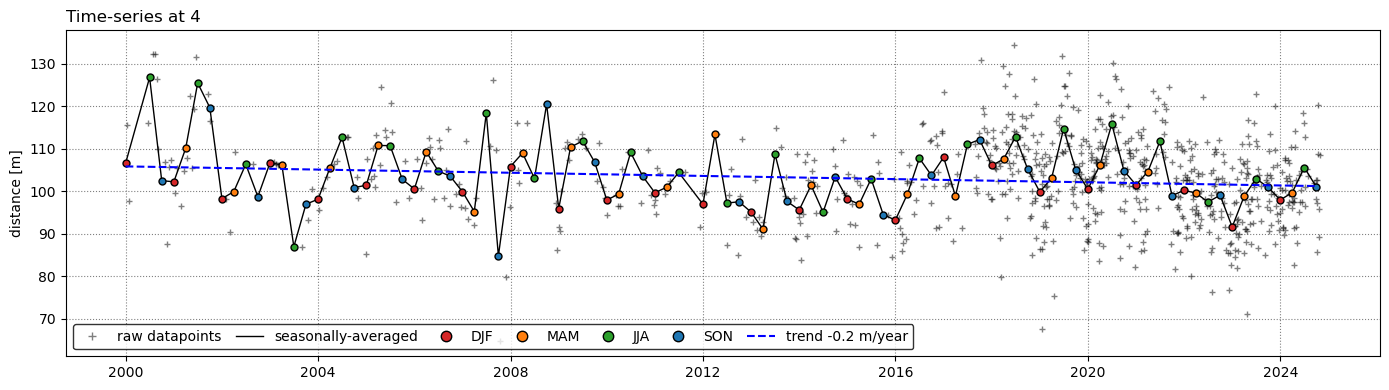

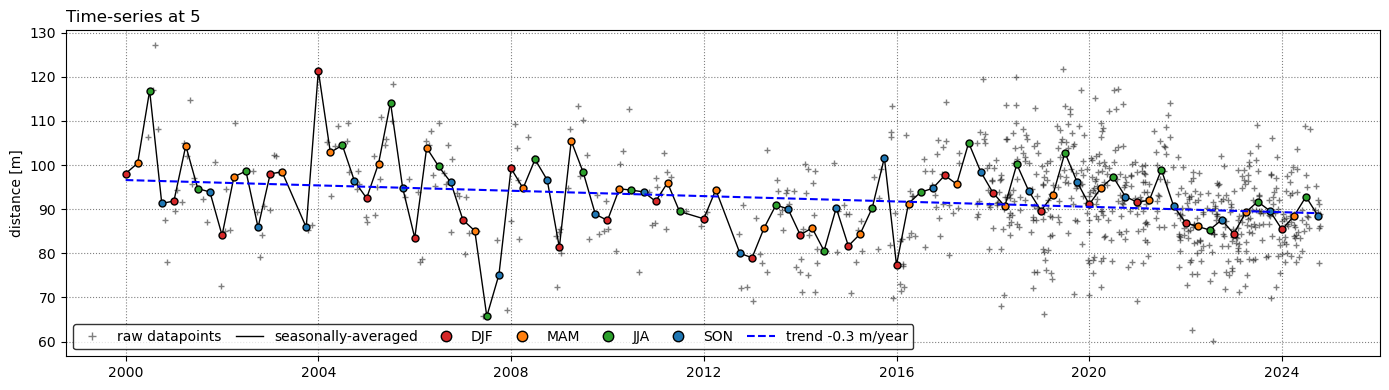

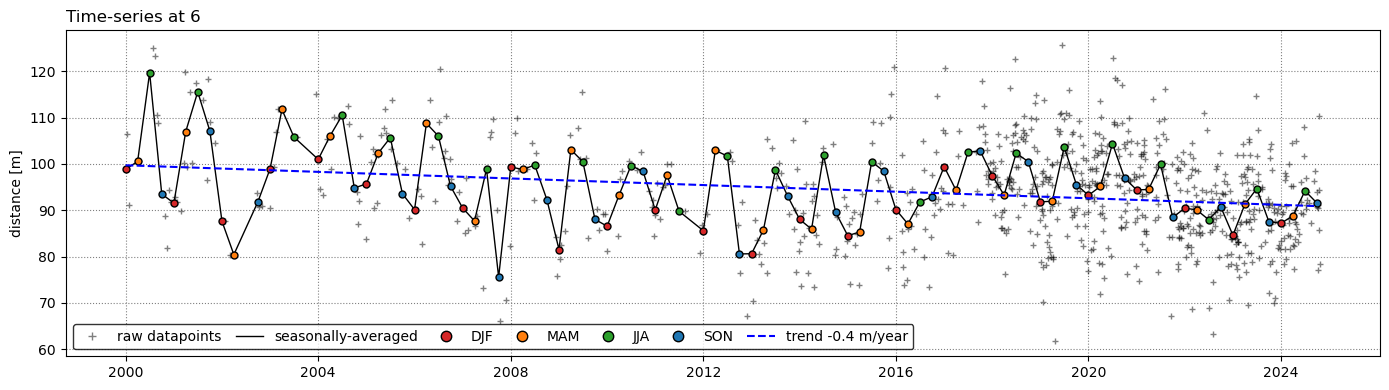

In [99]:
fp_seasonal = os.path.join('Data',sitename,'Output','img','seasonal_timeseries')
if not os.path.exists(fp_seasonal): os.makedirs(fp_seasonal)

print('Outputs will be saved in %s'%fp_seasonal)
season_colors = {'DJF':'C3', 'MAM':'C1', 'JJA':'C2', 'SON':'C0'}
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline seasonal averages (DJF, MAM, JJA, SON)
    dict_seas, dates_seas, chainage_seas, list_seas = SDS_transects.seasonal_average(dates_nonan, chainage)
    
    # calculate long-term trend
    trend, y =  SDS_transects.calculate_trend(dates_seas, chainage_seas)
    
    # plot seasonal averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_seas, chainage_seas, '-', lw=1, color='k', mfc='w', ms=4, label='seasonally-averaged')
    for k,seas in enumerate(dict_seas.keys()):
        ax.plot(dict_seas[seas]['dates'], dict_seas[seas]['chainages'],
                 'o', mec='k', color=season_colors[seas], label=seas,ms=5)
    ax.plot(dates_seas,y,'--',color='b', label='trend %.1f m/year'%trend)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)
    fig.savefig(os.path.join(fp_seasonal,'%s_timeseries_seasonal'%sitename+'_transect'+key+'.jpg'), dpi=200)

plt.show()

### Monthly averages

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.monthly_average()` and plot them.

Outputs will be saved in Data/Caleta_Olivia/Output/img/monthly_timeseries


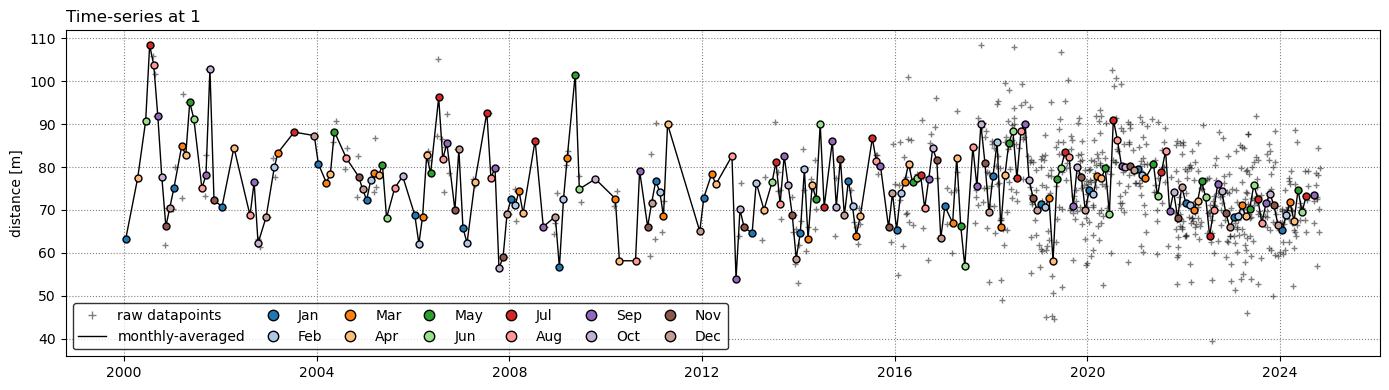

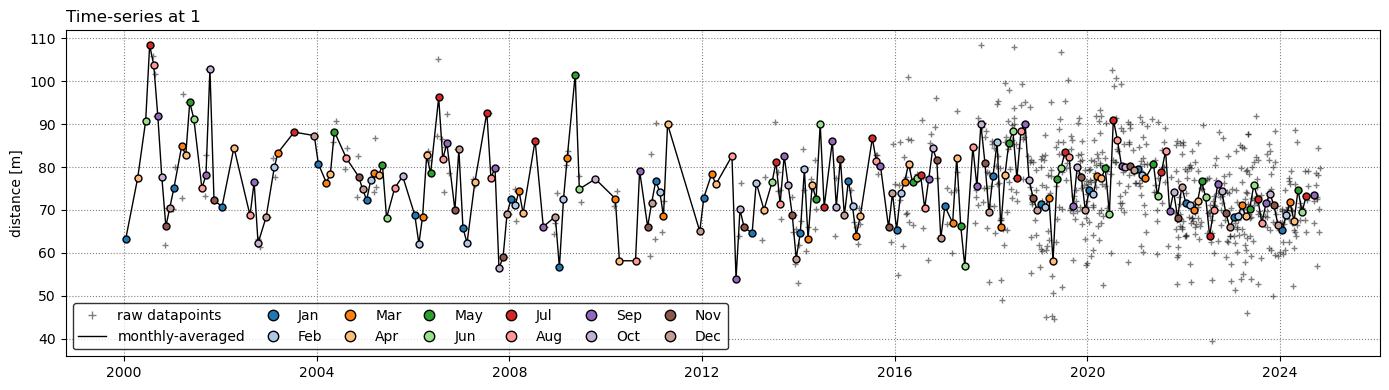

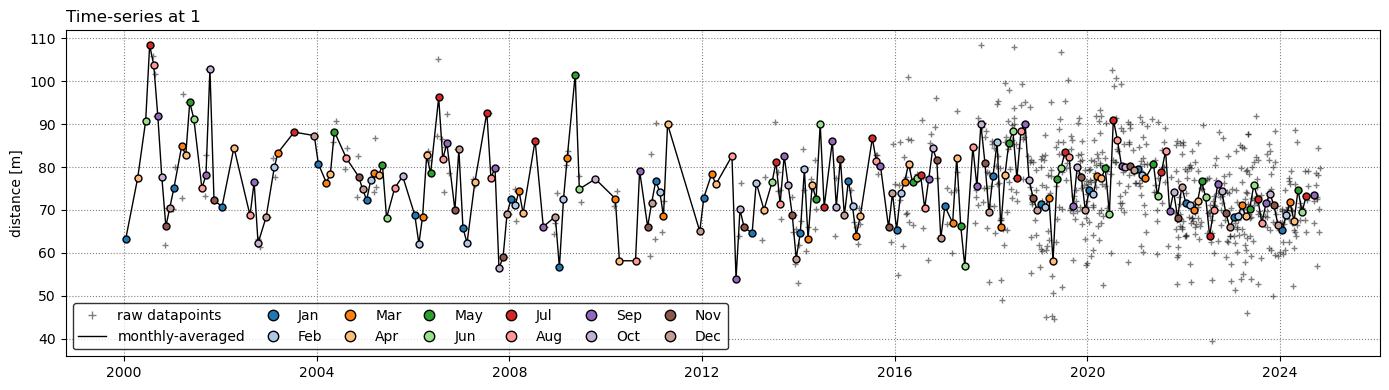

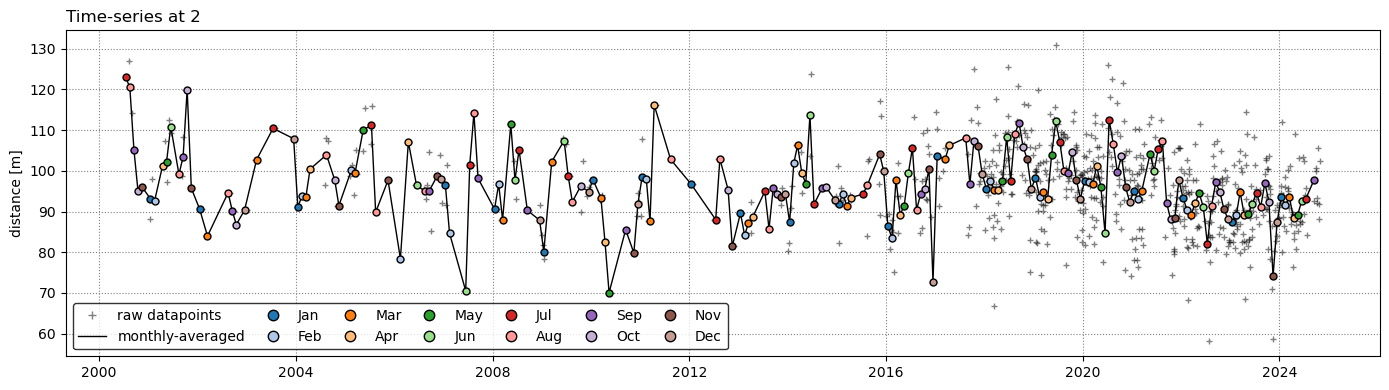

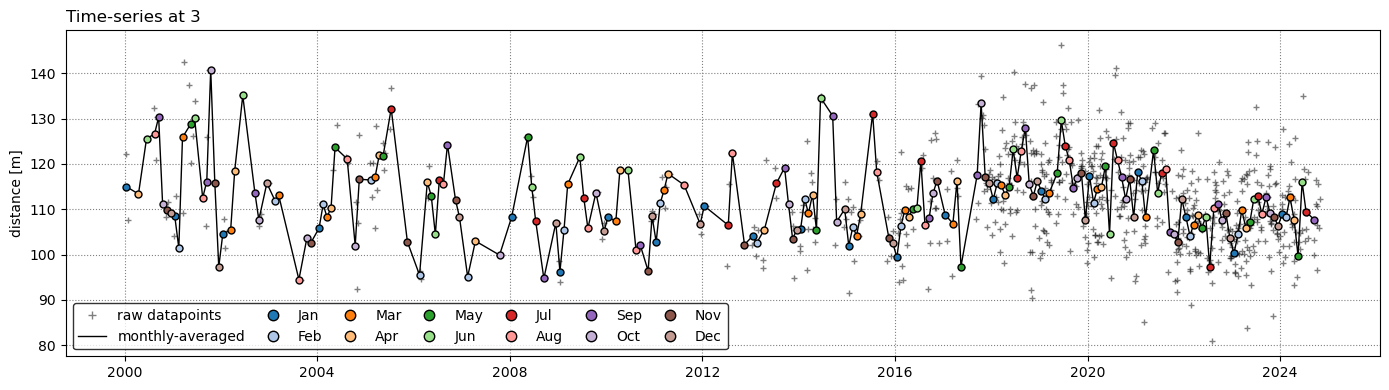

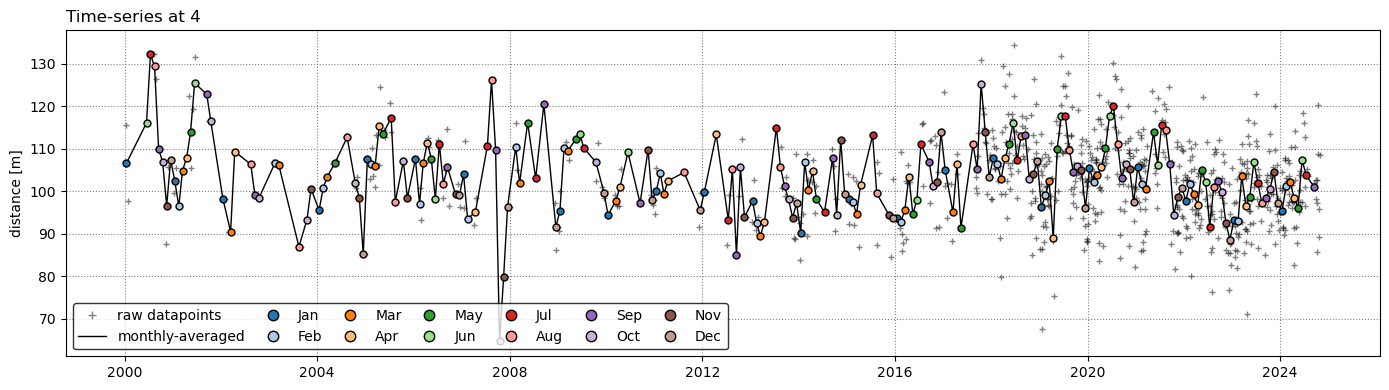

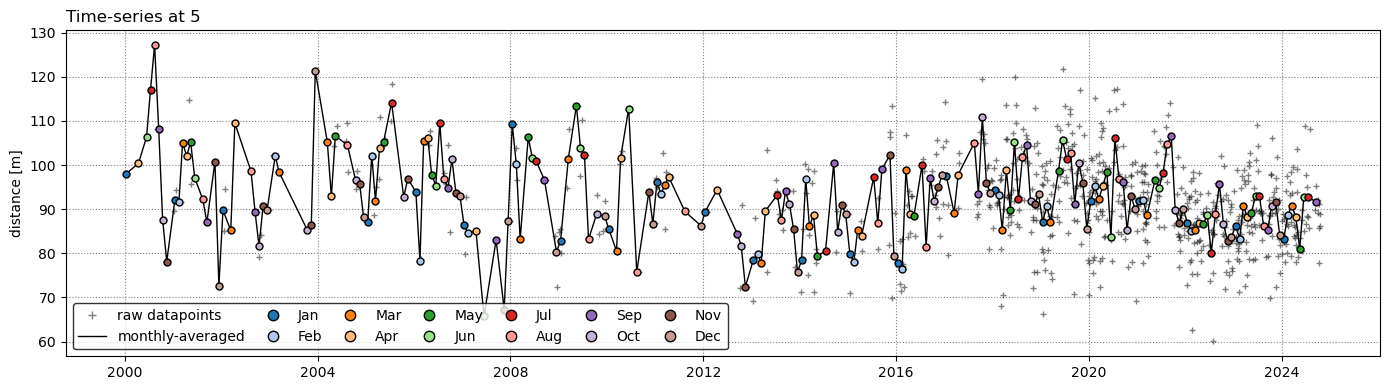

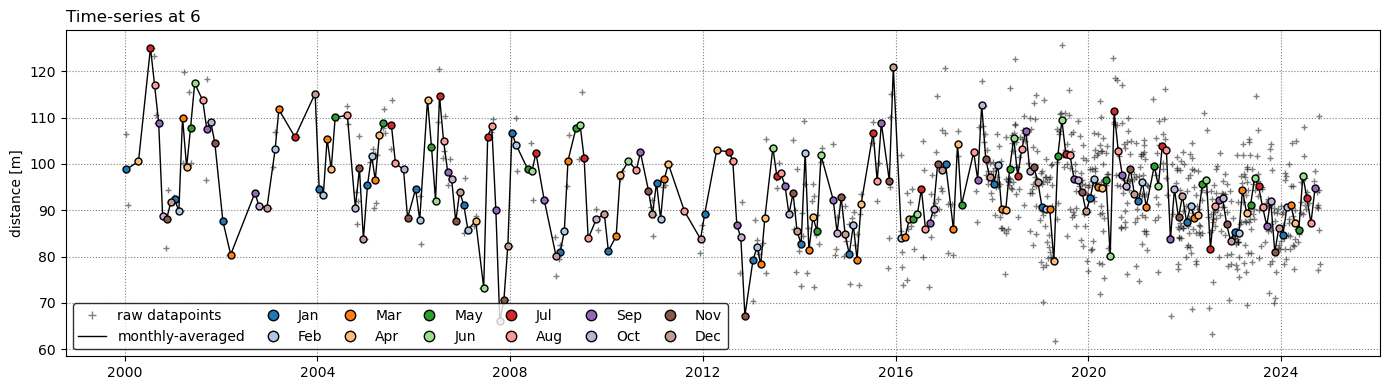

In [102]:
fp_monthly = os.path.join('Data',sitename,'Output','img','monthly_timeseries')
if not os.path.exists(fp_monthly): os.makedirs(fp_monthly)
print('Outputs will be saved in %s'%fp_monthly)

month_colors = plt.get_cmap('tab20')
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline monthly averages
    dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
    
    # plot monthly averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_month, chainage_month, '-', lw=1, color='k', mfc='w', ms=4, label='monthly-averaged')
    for k,month in enumerate(dict_month.keys()):
        ax.plot(dict_month[month]['dates'], dict_month[month]['chainages'],
                 'o', mec='k', color=month_colors(k), label=month,ms=5)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)
    fig.savefig(os.path.join(fp_seasonal,'%s_timeseries_monthly'%sitename+'_transect'+key+'.jpg'), dpi=200)

plt.show()

## Timeseries plot for all transects

To have an idea of the general coastal evolution in this area, we reduce all shoreline variations to the same starting point, and we plot cross-shore change for all transects. The starting point is identified as the first point in time where a shoreline is available in the dataset for all transects, once despiking has been done. 

In [103]:
# Identify the columns with distances (exclude 'Unnamed: 0' and 'dates')
distance_columns = df.columns[2:]  # Assuming columns 2 onward contain distances

# Find the first row with no NaN values in the distance columns
reference_row = df.dropna(subset=distance_columns).iloc[0][distance_columns]

# Subtract the reference row values from all rows in the distance columns
df_reference = df.copy()
df_reference[distance_columns] = df_reference[distance_columns].sub(reference_row, axis=1)

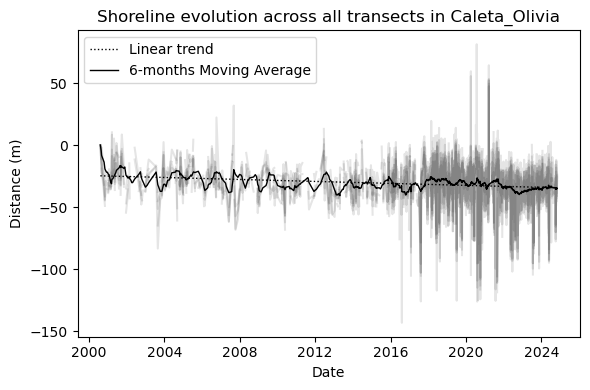

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Identify the distance columns (assuming the columns with numerical distances start from index 2 onward)
distance_columns = df.columns[2:]

# Identify the first row where there are no NaN values in any distance column
first_valid_index = df.dropna(subset=distance_columns).index[0]

# Clip the DataFrame starting from this index
df_clipped = df.loc[first_valid_index:].copy()
df_clipped_reference = df_reference.loc[first_valid_index:].copy()

# Set 'dates' as the index for time-based rolling and regression purposes
df_clipped_reference.set_index(df_clipped['dates'], inplace=True)

# Calculate the mean distance for each date across all distance columns
df_clipped_reference['mean_distance'] = df_clipped_reference[distance_columns].mean(axis=1)

# Remove rows with NaN values in 'mean_distance' for regression
non_nan_indices = df_clipped_reference['mean_distance'].notna()
date_ordinal = df_clipped_reference.index[non_nan_indices].map(lambda x: x.toordinal()).values.reshape(-1, 1)
mean_distance_values = df_clipped_reference['mean_distance'][non_nan_indices].values.reshape(-1, 1)

# Fit a linear regression model
model = LinearRegression()
model.fit(date_ordinal, mean_distance_values)
linear_trendline = model.predict(date_ordinal)

# Calculate the 6-months moving average using the index as datetime
df_clipped_reference['semi-yearly_moving_avg'] = df_clipped_reference['mean_distance'].rolling(window='182D').mean()

# Plot each row in the clipped distance columns with black lines and 10% transparency
plt.figure(figsize=(6, 4))

for col in distance_columns:
    plt.plot(df_clipped_reference.index, df_clipped_reference[col], color='black', alpha=0.1)

# Plot the linear trendline in red
plt.plot(df_clipped_reference.index[non_nan_indices], linear_trendline, color='k', linewidth=1, linestyle=':', label='Linear trend')

# Plot the yearly moving average trendline in blue
plt.plot(df_clipped_reference.index, df_clipped_reference['semi-yearly_moving_avg'], color='k', linestyle='-',linewidth=1, label='6-months Moving Average')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Distance (m)')
plt.title('Shoreline evolution across all transects in %s'%sitename)
plt.legend(loc='best')
plt.xticks()
plt.tight_layout()

plt.savefig(os.path.join(img_dir,'%s_timeseries_merged'%sitename+'.jpg'), dpi=300)

# Show the plot
plt.show()

## Acknowledgments
This work is based on the CoasSat tool. Please give credit to the original repository if you use this work, and make sure you visit [the original repository](https://github.com/kvos/CoastSat) and cite the relevant papers:

- Vos K., Splinter K.D., Harley M.D., Simmons J.A., Turner I.L. (2019). CoastSat: a Google Earth Engine-enabled Python toolkit to extract shorelines from publicly available satellite imagery. *Environmental Modelling and Software*. 122, 104528. https://doi.org/10.1016/j.envsoft.2019.104528 (Open Access)

- Vos K., Harley M.D., Splinter K.D., Simmons J.A., Turner I.L. (2019). Sub-annual to multi-decadal shoreline variability from publicly available satellite imagery. *Coastal Engineering*. 150, 160–174. https://doi.org/10.1016/j.coastaleng.2019.04.004

- Vos K., Harley M.D., Splinter K.D., Walker A., Turner I.L. (2020). Beach slopes from satellite-derived shorelines. *Geophysical Research Letters*. 47(14). https://doi.org/10.1029/2020GL088365 (Open Access preprint [here](https://www.essoar.org/doi/10.1002/essoar.10502903.2))

- Vos, K. and Deng, W. and Harley, M. D. and Turner, I. L. and Splinter, K. D. M. (2022). Beach-face slope dataset for Australia. *Earth System Science Data*. volume 14, 3, p. 1345--1357. https://doi.org/10.5194/essd-14-1345-2022

- Vos, K., Harley, M.D., Turner, I.L. et al. Pacific shoreline erosion and accretion patterns controlled by El Niño/Southern Oscillation. *Nature Geosciences*. 16, 140–146 (2023). https://doi.org/10.1038/s41561-022-01117-8

The code the FES2022 Tide product, funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

The modifications done within CoastSat.Venice were done in the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
